In [11]:
from pprint import pprint

import matplotlib.pyplot as plt
from datasets import load_dataset

In [12]:
volcano_data = load_dataset("easytpp/volcano")
taobao_data = load_dataset("easytpp/taobao")
retweet_data = load_dataset("easytpp/retweet")
stackoverflow_data = load_dataset("easytpp/stackoverflow")
taxi_data = load_dataset("easytpp/taxi")
amazon_data = load_dataset("easytpp/amazon")
earthquake_data = load_dataset("easytpp/earthquake")

In [13]:
max(max(taobao_data["test"]["time_since_start"]))

4.708316327447124

In [14]:
def normalize_times_to_1(dataset):
    normalized_dataset = {}

    # Process each split separately
    for split in dataset.keys():
        # Find max time for this specific split
        all_times = []
        for example in dataset[split]:
            all_times.extend(example["time_since_start"])

        max_time = max(all_times)

        # Define normalization function for this split
        def normalize_example(example):
            return {
                "seq_len": example["seq_len"],
                "type_event": example["type_event"],
                "seq_idx": example["seq_idx"],
                "time_since_start": [time / max_time for time in example["time_since_start"]],
                "time_since_last_event": [time / max_time for time in example["time_since_last_event"]],
                "dim_process": example["dim_process"],
            }

        # Apply normalization while preserving Dataset type
        normalized_dataset[split] = dataset[split].map(normalize_example)

    return normalized_dataset


volcano_data = normalize_times_to_1(volcano_data)
taobao_data = normalize_times_to_1(taobao_data)
retweet_data = normalize_times_to_1(retweet_data)
stackoverflow_data = normalize_times_to_1(stackoverflow_data)
taxi_data = normalize_times_to_1(taxi_data)
amazon_data = normalize_times_to_1(amazon_data)
earthquake_data = normalize_times_to_1(earthquake_data)

In [15]:
def print_stats(dataset, split="test"):
    dataset = dataset[split]
    stats = {
        "num_sequences": len(dataset),
        "max_sequence_length": 0,
        "min_sequence_length": 1000000,
        "max_event_time": 0,
        "min_event_time": 1000000,
    }
    seq_lengths = [len(seq["time_since_last_event"]) for seq in dataset]
    times_since_last_event = [time for seq in dataset for time in seq["time_since_last_event"]]
    min_delta_event_time = min(times_since_last_event)
    max_delta_event_time = max(times_since_last_event)
    min_seq_length = min(seq_lengths)
    max_seq_length = max(seq_lengths)
    avg_seq_length = sum(seq_lengths) / len(seq_lengths)
    avg_delta_event_time = sum(times_since_last_event) / len(times_since_last_event)
    stats["max_sequence_length"] = max_seq_length
    stats["min_sequence_length"] = min_seq_length
    stats["num_sequences"] = len(seq_lengths)
    stats["avg_sequence_length"] = avg_seq_length
    stats["max_event_time"] = max_delta_event_time
    stats["min_event_time"] = min_delta_event_time
    stats["avg_event_time"] = avg_delta_event_time
    encoutered_marks = set()
    for seq in dataset:
        for mark in seq["type_event"]:
            if mark not in encoutered_marks:
                encoutered_marks.add(mark)
    stats["num_marks"] = len(encoutered_marks)
    pprint(stats)

# Dataset Stats Prints

## TaoBao

In [41]:
taobao_data

{'train': Dataset({
     features: ['dim_process', 'seq_idx', 'seq_len', 'time_since_start', 'time_since_last_event', 'type_event'],
     num_rows: 1300
 }),
 'validation': Dataset({
     features: ['dim_process', 'seq_idx', 'seq_len', 'time_since_start', 'time_since_last_event', 'type_event'],
     num_rows: 200
 }),
 'test': Dataset({
     features: ['dim_process', 'seq_idx', 'seq_len', 'time_since_start', 'time_since_last_event', 'type_event'],
     num_rows: 500
 })}

In [16]:
print_stats(taobao_data)

{'avg_event_time': 0.003979462753628967,
 'avg_sequence_length': 56.91,
 'max_event_time': 0.08722266420221501,
 'max_sequence_length': 64,
 'min_event_time': 0.0,
 'min_sequence_length': 32,
 'num_marks': 17,
 'num_sequences': 500}


## Retweet

In [17]:
print_stats(retweet_data)

{'avg_event_time': 0.004215946653557168,
 'avg_sequence_length': 109.2325,
 'max_event_time': 0.860236285580097,
 'max_sequence_length': 264,
 'min_event_time': 0.0,
 'min_sequence_length': 50,
 'num_marks': 3,
 'num_sequences': 2000}


## Stackoverflow

In [18]:
print_stats(stackoverflow_data)

{'avg_event_time': 0.013510163001317162,
 'avg_sequence_length': 66.12967581047381,
 'max_event_time': 0.2717740280160645,
 'max_sequence_length': 101,
 'min_event_time': 0.0,
 'min_sequence_length': 41,
 'num_marks': 21,
 'num_sequences': 401}


## Taxi

In [19]:
print_stats(taxi_data)

{'avg_event_time': 0.012640938078432933,
 'avg_sequence_length': 37.05,
 'max_event_time': 0.30762841601250773,
 'max_sequence_length': 38,
 'min_event_time': 0.0,
 'min_sequence_length': 36,
 'num_marks': 10,
 'num_sequences': 400}


## Amazon

In [20]:
print_stats(amazon_data)

{'avg_event_time': 0.0076950151933318075,
 'avg_sequence_length': 45.40680713128039,
 'max_event_time': 0.012134090437262303,
 'max_sequence_length': 94,
 'min_event_time': 0.0,
 'min_sequence_length': 14,
 'num_marks': 16,
 'num_sequences': 1851}


# Plots

In [21]:
def plot_stats(dataset, splits=["train"]):
    # Extract the data for each split
    split_data = {split: dataset[split] for split in splits}

    # Create subplots
    fig, axes = plt.subplots(len(splits) + 1, 2, figsize=(20, 7 * len(splits)))

    for i, split in enumerate(splits):
        data = split_data[split]
        seq_len = data["seq_len"]
        time_since_last_event = data["time_since_last_event"]

        # Histogram of the seq_len
        axes[i, 0].hist(seq_len, bins=20, edgecolor="k")
        axes[i, 0].set_title(f"Histogram of Sequence Length ({split})")
        axes[i, 0].set_xlabel("Sequence Length")
        axes[i, 0].set_ylabel("Frequency")

        # Histogram of the time_since_last_event
        axes[i, 1].hist(time_since_last_event, bins=20, edgecolor="k")
        axes[i, 1].set_title(f"Histogram of Time Since Last Event ({split})")
        axes[i, 1].set_xlabel("Time Since Last Event")
        axes[i, 1].set_ylabel("Frequency")
        # axes[i, 0].set_xscale('log')

        # axes[i, 0].set_yscale('log')
        # axes[i, 1].set_xscale('log')
        axes[i, 1].set_yscale("log")

    plt.tight_layout()
    plt.show()

In [22]:
def plot_stats_per_event_type(dataset, splits=["train"]):
    # Extract the data for each split
    split_data = {split: dataset[split] for split in splits}

    # Create subplots
    num_events = dataset["train"][0]["dim_process"]
    fig, axes = plt.subplots(len(splits) * num_events, 2, figsize=(20, 5 * len(splits) * num_events))

    for i, split in enumerate(splits):
        data = split_data[split]

        for event_type in range(num_events):
            print(f"Event Type {event_type} for split {split}")
            event_mask = [[d == event_type for d in x["type_event"]] for x in data]
            time_since_last_event = [[e for e, m in zip(d["time_since_last_event"], e_m) if m] for d, e_m in zip(data, event_mask)]
            seq_len = [len(x) for x in time_since_last_event]
            # Histogram of the seq_len
            axes[i * num_events + event_type, 0].hist(seq_len, bins=20, edgecolor="k", alpha=0.5, label=f"Event Type {event_type}")
            axes[i * num_events + event_type, 0].set_title(f"Histogram of Sequence Length ({split})")
            axes[i * num_events + event_type, 0].set_xlabel("Sequence Length")
            axes[i * num_events + event_type, 0].set_ylabel("Frequency")

            # Histogram of the time_since_last_event
            axes[i * num_events + event_type, 1].hist(
                time_since_last_event, bins=20, edgecolor="k", alpha=0.5, label=f"Event Type {event_type}"
            )
            axes[i * num_events + event_type, 1].set_title(f"Histogram of Time Since Last Event ({split})")
            axes[i * num_events + event_type, 1].set_xlabel("Time Since Last Event")
            axes[i * num_events + event_type, 1].set_ylabel("Frequency")

        axes[i * num_events + event_type, 0].legend()
        axes[i * num_events + event_type, 1].legend()
        axes[i * num_events + event_type, 1].set_yscale("log")

    plt.tight_layout()
    plt.show()

In [44]:
import random
from collections import defaultdict

import numpy as np
import seaborn as sns


# --- Helper Function ---


def get_max_time(dataset, split="train"):
    """
    Calculates the maximum event time ('time_since_start') across all trajectories
    in a split of a Hugging Face Dataset object.
    """
    max_t = 0
    data_split = dataset.get(split)
    if data_split is None:
        print(f"Warning: Split '{split}' not found in dataset.")
        return 1.0  # Default max time

    # Check if 'time_since_start' column exists
    if "time_since_start" not in data_split.column_names:
        print(f"Error: 'time_since_start' column not found in dataset split '{split}'. Cannot determine max time.")
        return 1.0  # Default max time

    for trajectory in data_split:
        times = trajectory.get("time_since_start")
        # Ensure times is a non-empty list or array
        if times and hasattr(times, "__len__") and len(times) > 0:
            # Check for potential nested lists or other issues if max fails
            try:
                current_max = np.max(times)
                if isinstance(current_max, (int, float)):  # Ensure it's a number
                    max_t = max(max_t, current_max)
            except (TypeError, ValueError) as e:
                print(f"Warning: Could not compute max time for a trajectory: {e}. Skipping.")
                print(f"Problematic 'time_since_start' value: {times}")

    return max_t if max_t > 0 else 1.0  # Avoid max_time being 0


# --- Visualization Functions ---


def plot_aggregate_rate(dataset, split="train", n_bins=50, max_time=None, ax=None):
    """
    Plots the aggregate event rate over time using a Hugging Face Dataset.
    Assumes 'time_since_start' contains absolute event times.

    Args:
        dataset (dict): Dictionary containing Hugging Face Dataset objects per split.
        split (str): The dataset split to use (e.g., 'train').
        n_bins (int): Number of time bins.
        max_time (float, optional): Maximum time for the plot range. If None, calculated from data.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, creates a new figure.
    """
    if ax is None:
        fig_created = True
        fig, ax = plt.subplots(figsize=(12, 4))
    else:
        fig_created = False

    data_split = dataset.get(split)
    if data_split is None:
        print(f"No data found for split '{split}'.")
        return

    num_trajectories = len(data_split)
    if num_trajectories == 0:
        print(f"No trajectories in split '{split}'.")
        return

    if "time_since_start" not in data_split.column_names:
        print(f"Error: 'time_since_start' column not found in dataset split '{split}'. Cannot plot aggregate rate.")
        return

    if max_time is None:
        max_time = get_max_time(dataset, split)

    # Define time bins
    bins = np.linspace(0, max_time, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    if bin_width == 0:  # Avoid division by zero if max_time is 0 or n_bins is 1
        print("Warning: Cannot calculate rate, time bin width is zero.")
        return

    # Count events in each bin
    counts = np.zeros(n_bins)

    for trajectory in data_split:
        times = trajectory.get("time_since_start", [])
        # Ensure times is a list/array of numbers
        if times and isinstance(times, (list, np.ndarray)):
            try:
                # Filter out non-numeric types if necessary, though HF datasets usually handle this
                numeric_times = [t for t in times if isinstance(t, (int, float))]
                if numeric_times:
                    hist, _ = np.histogram(numeric_times, bins=bins)
                    counts += hist
            except Exception as e:
                print(f"Warning: Could not process times for a trajectory: {e}")
                print(f"Problematic 'time_since_start': {times}")

    # Calculate rate (average events per trajectory per unit time)
    rate = counts / (num_trajectories * bin_width)

    # Plotting
    ax.plot(bin_centers, rate, marker=".", linestyle="-")
    ax.set_title(f"Aggregate Event Rate ({split} split)")
    ax.set_xlabel("Time (from time_since_start)")
    ax.set_ylabel("Avg. Events / Trajectory / Time Unit")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xlim(0, max_time)
    ax.set_ylim(bottom=0)

    if fig_created:  # Only show if we created the figure
        plt.tight_layout()
        plt.show()


def plot_rate_per_mark(dataset, split="train", n_bins=50, max_time=None, ax=None):
    """
    Plots the event rate per mark over time using a Hugging Face Dataset.
    Assumes 'time_since_start' contains absolute event times and 'type_event' contains marks.

    Args:
        dataset (dict): Dictionary containing Hugging Face Dataset objects per split.
        split (str): The dataset split to use.
        n_bins (int): Number of time bins.
        max_time (float, optional): Maximum time for the plot range. If None, calculated from data.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, creates a new figure.
    """
    if ax is None:
        fig_created = True
        fig, ax = plt.subplots(figsize=(12, 5))
    else:
        fig_created = False

    data_split = dataset.get(split)
    if data_split is None:
        print(f"No data found for split '{split}'.")
        return

    num_trajectories = len(data_split)
    if num_trajectories == 0:
        print(f"No trajectories in split '{split}'.")
        return

    # Check for required columns
    required_cols = ["dim_process", "time_since_start", "type_event"]
    if not all(col in data_split.column_names for col in required_cols):
        print(f"Error: Dataset split '{split}' missing one or more required columns: {required_cols}")
        return

    # Infer number of marks (dim_process) - Assuming it's constant
    # Take it from the first row, ensure it's an integer
    try:
        dim_process = int(data_split[0]["dim_process"])
    except (ValueError, TypeError):
        print("Error: 'dim_process' feature is not a valid integer in the first row.")
        return

    if max_time is None:
        max_time = get_max_time(dataset, split)

    # Define time bins
    bins = np.linspace(0, max_time, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_width = bins[1] - bins[0]
    if bin_width == 0:
        print("Warning: Cannot calculate rate, time bin width is zero.")
        return

    # Count events per mark in each bin
    counts_per_mark = np.zeros((dim_process, n_bins))

    for trajectory in data_split:
        times = np.array(trajectory.get("time_since_start", []))
        types = np.array(trajectory.get("type_event", []))

        if len(times) != len(types) or len(times) == 0:
            continue  # Skip if data is inconsistent or empty

        # Ensure types are integers
        try:
            types = types.astype(int)
        except (ValueError, TypeError):
            print("Warning: Could not convert 'type_event' to integers for a trajectory. Skipping.")
            continue

        for mark in range(dim_process):
            try:
                # Filter times corresponding to the current mark
                mark_times = times[types == mark]
                # Ensure mark_times contains numeric data before histogramming
                numeric_mark_times = [t for t in mark_times if isinstance(t, (int, float))]
                if numeric_mark_times:
                    hist, _ = np.histogram(numeric_mark_times, bins=bins)
                    counts_per_mark[mark, :] += hist
            except IndexError:
                print(f"Warning: Index error processing mark {mark}. Check data consistency (e.g., mark values vs dim_process).")
            except Exception as e:
                print(f"Warning: Could not process mark {mark} for a trajectory: {e}")

    # Calculate rates
    rates_per_mark = counts_per_mark / (num_trajectories * bin_width)

    # Plotting
    colors = plt.cm.viridis(np.linspace(0, 1, dim_process))
    for mark in range(dim_process):
        ax.plot(bin_centers, rates_per_mark[mark, :], marker=".", linestyle="-", label=f"Mark {mark}", color=colors[mark])

    ax.set_title(f"Event Rate per Mark ({split} split)")
    ax.set_xlabel("Time (from time_since_start)")
    ax.set_ylabel("Avg. Events / Trajectory / Time Unit")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xlim(0, max_time)
    ax.set_ylim(bottom=0)

    if fig_created:  # Only show if we created the figure
        plt.tight_layout()
        plt.show()


def plot_raster_sample(dataset, split="train", n_samples=10, max_time=None, ax=None, seed=None):
    """
    Creates a raster plot for a sample of trajectories from a Hugging Face Dataset.
    Assumes 'time_since_start' and 'type_event' columns exist.

    Args:
        dataset (dict): Dictionary containing Hugging Face Dataset objects per split.
        split (str): The dataset split to use.
        n_samples (int): Number of trajectories to sample and plot.
        max_time (float, optional): Maximum time for the plot range. If None, calculated from data.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, creates a new figure.
        seed (int, optional): Random seed for reproducibility of sampling.
    """
    if ax is None:
        fig_created = True
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig_created = False

    data_split = dataset.get(split)
    if data_split is None:
        print(f"No data found for split '{split}'.")
        return

    num_trajectories = len(data_split)
    if num_trajectories == 0:
        print(f"No trajectories in split '{split}'.")
        return

    # Check for required columns
    required_cols = ["dim_process", "time_since_start", "type_event"]
    if not all(col in data_split.column_names for col in required_cols):
        print(f"Error: Dataset split '{split}' missing one or more required columns: {required_cols}")
        return

    if num_trajectories < n_samples:
        print(f"Warning: Requested {n_samples} samples, but only {num_trajectories} trajectories available.")
        n_samples = num_trajectories

    if n_samples == 0:
        return

    # Sample indices
    if seed is not None:
        random.seed(seed)
    sampled_indices = random.sample(range(num_trajectories), n_samples)

    # Select the sampled trajectories (more efficient than iterating and filtering)
    # Note: This creates a new dataset view, doesn't load all into memory at once
    sampled_data = data_split.select(sampled_indices)

    # Infer number of marks from the first sampled trajectory
    try:
        dim_process = int(sampled_data[0]["dim_process"])
    except (ValueError, TypeError):
        print("Error: 'dim_process' feature is not a valid integer in the first sampled row.")
        return

    if max_time is None:
        # Calculate max_time only from the sampled trajectories for efficiency
        max_t_sample = 0
        for traj in sampled_data:
            times = traj.get("time_since_start")
            if times and hasattr(times, "__len__") and len(times) > 0:
                try:
                    current_max = np.max(times)
                    if isinstance(current_max, (int, float)):
                        max_t_sample = max(max_t_sample, current_max)
                except (TypeError, ValueError):
                    pass  # Ignore errors here, focus is on getting a reasonable max
        max_time = max_t_sample if max_t_sample > 0 else 1.0

    colors = plt.cm.viridis(np.linspace(0, 1, dim_process))

    # Plot events using scatter
    event_times = []
    y_positions = []
    event_colors = []
    for i, trajectory in enumerate(sampled_data):  # Iterate over the selected sample
        times = trajectory.get("time_since_start", [])
        types = trajectory.get("type_event", [])

        if (
            not isinstance(times, (list, np.ndarray))
            or not isinstance(types, (list, np.ndarray))
            or len(times) != len(types)
            or len(times) == 0
        ):
            continue

        try:
            # Ensure types are integers for indexing colors
            types = np.array(types).astype(int)
            times = np.array(times)  # Ensure times are numpy array for potential filtering

            # Filter out non-numeric times just in case
            valid_indices = [idx for idx, t in enumerate(times) if isinstance(t, (int, float))]
            times = times[valid_indices]
            types = types[valid_indices]

            for t, type_ in zip(times, types):
                if 0 <= type_ < dim_process:  # Check if type is valid
                    event_times.append(t)
                    y_positions.append(i)  # Use sample index for y-position
                    event_colors.append(colors[type_])
                else:
                    print(f"Warning: Invalid event type {type_} encountered in sampled trajectory {i}. Skipping event.")

        except Exception as e:
            print(f"Warning: Error processing sampled trajectory {i}: {e}")

    # Using scatter for better color control per event
    if event_times:  # Only plot if there's data
        ax.scatter(event_times, y_positions, c=event_colors, marker="|", s=100)  # s is marker size
    else:
        print("No valid events found in the sample to plot.")

    ax.set_title(f"Raster Plot ({n_samples} Sampled Trajectories from {split} split)")
    ax.set_xlabel("Time (from time_since_start)")
    ax.set_ylabel("Sampled Trajectory Index")
    ax.set_yticks(range(n_samples))
    # ax.set_yticklabels([f"Orig Idx {sampled_indices[i]}" for i in range(n_samples)]) # Optional
    ax.set_ylim(-0.5, n_samples - 0.5)
    ax.set_xlim(0, max_time)
    ax.grid(True, axis="x", linestyle="--", alpha=0.6)

    # Add a legend for marks
    legend_elements = [
        plt.Line2D([0], [0], marker="|", color=colors[mark], linestyle="None", markersize=10, label=f"Mark {mark}")
        for mark in range(dim_process)
    ]
    ax.legend(handles=legend_elements, title="Event Marks", bbox_to_anchor=(1.05, 1), loc="upper left")

    if fig_created:  # Only show if we created the figure
        plt.tight_layout()
        plt.show()


def plot_event_count_heatmap(dataset, split="train", n_bins=50, max_time=None, normalize=True, ax=None):
    """
    Plots a heatmap of event counts per mark over time using a Hugging Face Dataset.
    Assumes 'time_since_start', 'type_event', 'dim_process' columns exist.

    Args:
        dataset (dict): Dictionary containing Hugging Face Dataset objects per split.
        split (str): The dataset split to use.
        n_bins (int): Number of time bins.
        max_time (float, optional): Maximum time for the plot range. If None, calculated from data.
        normalize (bool): If True, normalize counts by the number of trajectories.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, creates a new figure.
    """
    if ax is None:
        fig_created = True
        fig, ax = plt.subplots(figsize=(12, 5))
    else:
        fig_created = False

    data_split = dataset.get(split)
    if data_split is None:
        print(f"No data found for split '{split}'.")
        return

    num_trajectories = len(data_split)
    if num_trajectories == 0:
        print(f"No trajectories in split '{split}'.")
        return

    # Check for required columns
    required_cols = ["dim_process", "time_since_start", "type_event"]
    if not all(col in data_split.column_names for col in required_cols):
        print(f"Error: Dataset split '{split}' missing one or more required columns: {required_cols}")
        return

    # Infer number of marks
    try:
        dim_process = int(data_split[0]["dim_process"])
    except (ValueError, TypeError):
        print("Error: 'dim_process' feature is not a valid integer in the first row.")
        return

    if max_time is None:
        max_time = get_max_time(dataset, split)

    # Define time bins
    bins = np.linspace(0, max_time, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # For labeling ticks

    # Initialize count matrix (marks x time_bins)
    heatmap_counts = np.zeros((dim_process, n_bins))

    # Populate the heatmap counts
    for trajectory in data_split:
        times = np.array(trajectory.get("time_since_start", []))
        types = np.array(trajectory.get("type_event", []))

        if len(times) != len(types) or len(times) == 0:
            continue

        try:
            types = types.astype(int)
            # Filter out non-numeric times
            valid_indices = [idx for idx, t in enumerate(times) if isinstance(t, (int, float))]
            times = times[valid_indices]
            types = types[valid_indices]

            for mark in range(dim_process):
                mark_times = times[types == mark]
                if len(mark_times) > 0:  # Only histogram if there are times for this mark
                    hist, _ = np.histogram(mark_times, bins=bins)
                    heatmap_counts[mark, :] += hist

        except Exception as e:
            print(f"Warning: Could not process trajectory for heatmap: {e}")

    # Normalize counts (optional)
    if normalize and num_trajectories > 0:
        heatmap_data = heatmap_counts / num_trajectories
        cbar_label = "Avg Events / Trajectory / Bin"
    else:
        heatmap_data = heatmap_counts
        cbar_label = "Total Events / Bin"

    # Plotting the heatmap
    sns.heatmap(heatmap_data, ax=ax, cmap="viridis", cbar_kws={"label": cbar_label})

    # Set x-axis ticks and labels (show fewer labels for clarity)
    tick_positions = np.linspace(0, n_bins - 1, num=min(n_bins, 10), dtype=int)  # Show ~10 ticks
    ax.set_xticks(tick_positions + 0.5)  # Center ticks
    ax.set_xticklabels([f"{bin_centers[i]:.2f}" for i in tick_positions], rotation=45, ha="right")

    ax.set_yticks(np.arange(dim_process) + 0.5)
    ax.set_yticklabels([f"Mark {i}" for i in range(dim_process)], rotation=0)

    ax.set_xlabel("Time Bins (from time_since_start)")
    ax.set_ylabel("Event Mark")
    title = f"Event Count Heatmap ({split} split)"
    if normalize:
        title = f"Average {title}"
    ax.set_title(title)

    if fig_created:  # Only show if we created the figure
        plt.tight_layout()
        plt.show()


def plot_inter_event_times(dataset, split="train", n_bins=50, plot_type="all_consecutive"):
    """
    Plots histograms of inter-event times using a Hugging Face Dataset.
    Assumes 'time_since_start' and 'type_event' columns exist.

    Args:
        dataset (dict): Dictionary containing Hugging Face Dataset objects per split.
        split (str): The dataset split to use.
        n_bins (int): Number of bins for the histogram.
        plot_type (str): Type of inter-event time to plot:
                         'all_consecutive': Time between any two consecutive events.
                         'mark_to_next': Time from an event of a specific mark to the *next* event (any mark).
                         'time_since_last': Uses the 'time_since_last_event' feature directly.
    """
    data_split = dataset.get(split)
    if data_split is None:
        print(f"No data found for split '{split}'.")
        return

    num_trajectories = len(data_split)
    if num_trajectories == 0:
        print(f"No trajectories in split '{split}'.")
        return

    all_diffs = []

    if plot_type == "all_consecutive":
        if "time_since_start" not in data_split.column_names:
            print("Error: 'time_since_start' column required for plot_type='all_consecutive'.")
            return

        for trajectory in data_split:
            times = trajectory.get("time_since_start", [])
            # Ensure times are numeric and sortable
            if times and isinstance(times, (list, np.ndarray)):
                try:
                    numeric_times = np.sort([t for t in times if isinstance(t, (int, float))])
                    if len(numeric_times) > 1:
                        diffs = np.diff(numeric_times)
                        all_diffs.extend(diffs)
                except Exception as e:
                    print(f"Warning: Could not calculate time differences for a trajectory: {e}")

        if not all_diffs:
            print("No consecutive events found to calculate differences.")
            return

        plt.figure(figsize=(10, 5))
        plt.hist(all_diffs, bins=n_bins, edgecolor="k", alpha=0.7)
        plt.title(f"Histogram of Time Between Consecutive Events ({split} split)")
        plt.xlabel("Time Difference (dt from time_since_start)")
        plt.ylabel("Frequency")
        plt.yscale("log")  # Often useful for time differences
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    elif plot_type == "mark_to_next":
        required_cols = ["dim_process", "time_since_start", "type_event"]
        if not all(col in data_split.column_names for col in required_cols):
            print(f"Error: Dataset split '{split}' missing one or more required columns for plot_type='mark_to_next': {required_cols}")
            return

        # Infer number of marks
        try:
            dim_process = int(data_split[0]["dim_process"])
        except (ValueError, TypeError):
            print("Error: 'dim_process' feature is not a valid integer in the first row.")
            return

        diffs_by_mark = defaultdict(list)

        for trajectory in data_split:
            times = np.array(trajectory.get("time_since_start", []))
            types = np.array(trajectory.get("type_event", []))

            if len(times) != len(types) or len(times) < 2:
                continue

            try:
                # Sort by time
                valid_indices = [idx for idx, t in enumerate(times) if isinstance(t, (int, float))]
                if len(valid_indices) < 2:
                    continue  # Need at least 2 valid times

                times = times[valid_indices]
                types = types[valid_indices].astype(int)  # Assume types correspond to valid times

                sort_indices = np.argsort(times)
                times = times[sort_indices]
                types = types[sort_indices]

                for i in range(len(times) - 1):
                    current_mark = types[i]
                    time_diff = times[i + 1] - times[i]
                    if 0 <= current_mark < dim_process:  # Check mark validity
                        diffs_by_mark[current_mark].append(time_diff)
                    else:
                        print(f"Warning: Invalid mark {current_mark} encountered.")

            except Exception as e:
                print(f"Warning: Could not process trajectory for mark_to_next diffs: {e}")

        if not diffs_by_mark:
            print("No valid events found to calculate mark-to-next differences.")
            return

        # Plotting - create subplots for each mark
        n_marks = dim_process
        n_cols = 3
        n_rows = (n_marks + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
        axes = axes.flatten()  # Flatten to 1D array for easy iteration

        for mark in range(n_marks):
            ax = axes[mark]
            mark_diffs = diffs_by_mark.get(mark, [])
            if mark_diffs:
                ax.hist(mark_diffs, bins=n_bins, edgecolor="k", alpha=0.7)
                ax.set_title(f"Mark {mark} to Next Event")
                ax.set_xlabel("Time Difference (dt)")
                ax.set_ylabel("Frequency")
                ax.set_yscale("log")
                ax.grid(True, linestyle="--", alpha=0.6)
            else:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.set_title(f"Mark {mark} to Next Event")

        # Hide unused subplots
        for i in range(n_marks, len(axes)):
            fig.delaxes(axes[i])

        fig.suptitle(f"Time from Event Mark to Next Event ({split} split)", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent title overlap
        plt.show()

    elif plot_type == "time_since_last":
        # Plot histogram directly from the 'time_since_last_event' feature
        if "time_since_last_event" not in data_split.column_names:
            print("Error: 'time_since_last_event' column required for plot_type='time_since_last'.")
            return

        for trajectory in data_split:
            tsl = trajectory.get("time_since_last_event", [])
            if tsl and isinstance(tsl, (list, np.ndarray)):
                # Filter out potential non-numeric values or NaNs
                numeric_tsl = [t for t in tsl if isinstance(t, (int, float)) and np.isfinite(t)]
                all_diffs.extend(numeric_tsl)

        if not all_diffs:
            print("No valid 'time_since_last_event' data found.")
            return

        plt.figure(figsize=(10, 5))
        plt.hist(all_diffs, bins=n_bins, edgecolor="k", alpha=0.7)
        plt.title(f"Histogram of Time Since Last Event ({split} split)")
        plt.xlabel("Time Since Last Event (feature value)")
        plt.ylabel("Frequency")
        plt.yscale("log")
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Error: Unknown plot_type '{plot_type}'. Choose 'all_consecutive', 'mark_to_next', or 'time_since_last'.")


# plot_branching_ratio_matrix remains the same as it depends on an external matrix,
# not directly on the dataset structure for iteration.
def plot_branching_ratio_matrix(alpha_matrix, ax=None):
    """
    Plots the estimated branching ratio (influence) matrix as a heatmap.
    NOTE: This function requires the matrix 'alpha_matrix' to be pre-computed
          through Hawkes process parameter estimation.

    Args:
        alpha_matrix (np.ndarray): A square matrix where alpha[i, j] represents
                                   the influence of mark j on mark i.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, creates a new figure.
    """
    if not isinstance(alpha_matrix, np.ndarray) or alpha_matrix.ndim != 2 or alpha_matrix.shape[0] != alpha_matrix.shape[1]:
        print("Error: alpha_matrix must be a square numpy array.")
        return

    if ax is None:
        fig_created = True
        fig, ax = plt.subplots(figsize=(6, 5))
    else:
        fig_created = False

    dim_process = alpha_matrix.shape[0]
    sns.heatmap(
        alpha_matrix,
        annot=True,
        fmt=".3f",
        cmap="viridis",
        ax=ax,
        cbar_kws={"label": "Influence Magnitude (α_ij)"},
        linewidths=0.5,
        linecolor="black",
    )

    ax.set_xlabel("Influencing Mark (j)")
    ax.set_ylabel("Influenced Mark (i)")
    ax.set_title("Estimated Branching Ratio / Influence Matrix (α)")
    ax.set_xticklabels(range(dim_process))
    ax.set_yticklabels(range(dim_process), rotation=0)

    if fig_created:  # Only show if we created the figure
        plt.tight_layout()
        plt.show()


# --- Example Usage ---
# Assuming 'my_hf_dataset' is loaded and is a dictionary like:
# my_hf_dataset = {'train': Dataset(...), 'test': Dataset(...)}
#
# plot_aggregate_rate(my_hf_dataset, split='train')
# plot_rate_per_mark(my_hf_dataset, split='train')
# plot_raster_sample(my_hf_dataset, split='train', n_samples=15)
# plot_event_count_heatmap(my_hf_dataset, split='train', n_bins=60)
# plot_inter_event_times(my_hf_dataset, split='train', plot_type='all_consecutive')
# plot_inter_event_times(my_hf_dataset, split='train', plot_type='mark_to_next')
# plot_inter_event_times(my_hf_dataset, split='train', plot_type='time_since_last') # Use existing feature
#
# # For branching ratios (requires external estimation):
# # estimated_alpha = estimate_hawkes_params(my_hf_dataset['train']) # Your estimation code
# # plot_branching_ratio_matrix(estimated_alpha)

## Taxi

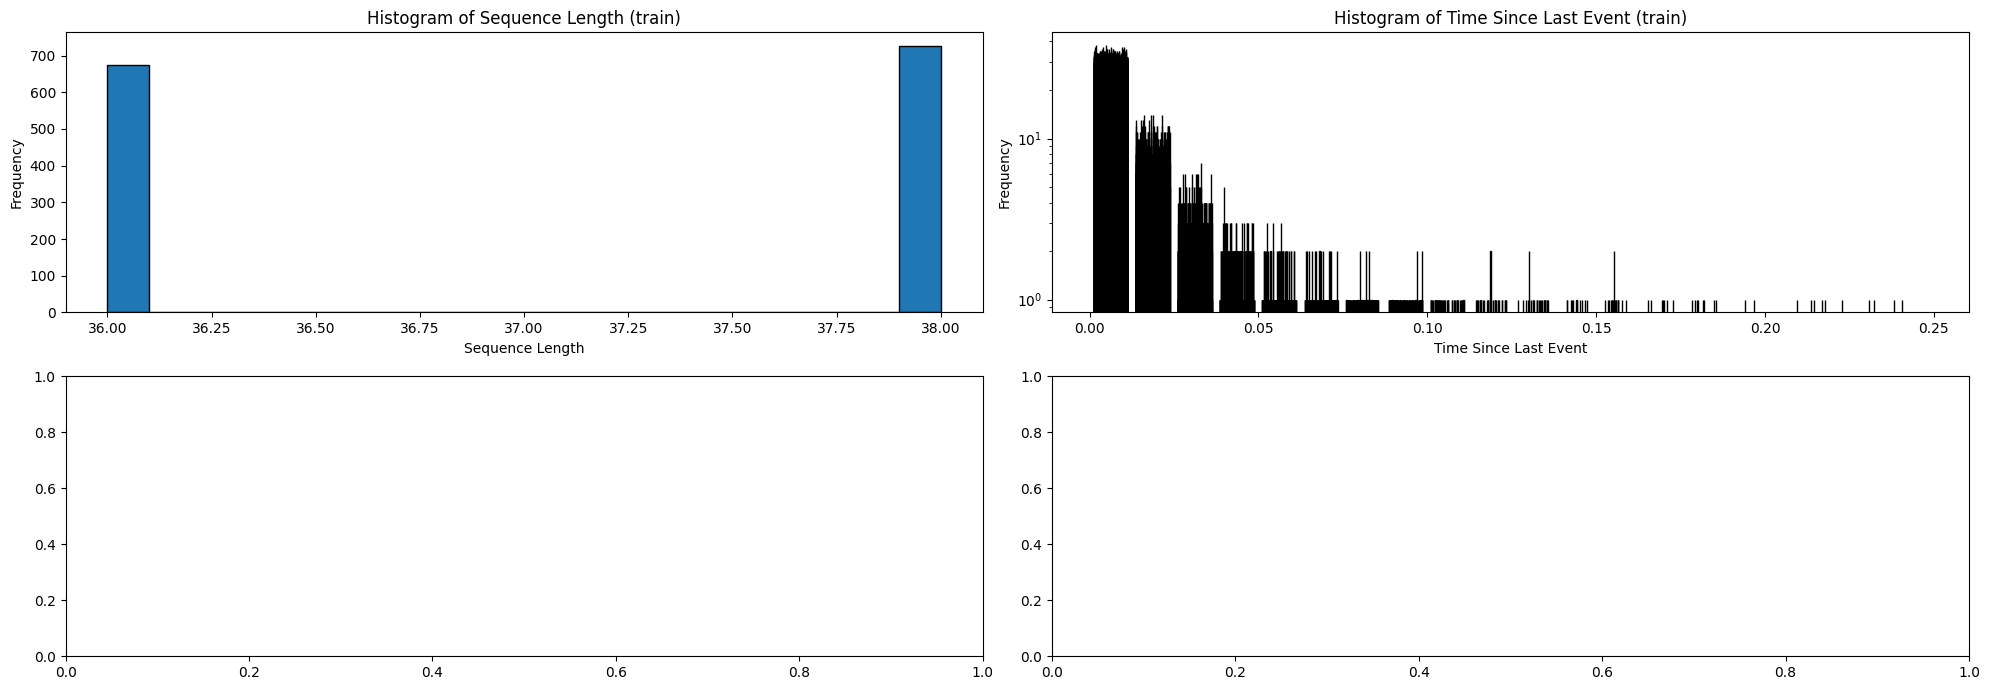

In [24]:
plot_stats(taxi_data)

In [25]:
taxi_data["train"]

Dataset({
    features: ['seq_len', 'time_since_start', 'seq_idx', 'time_since_last_event', 'type_event', 'dim_process'],
    num_rows: 1400
})

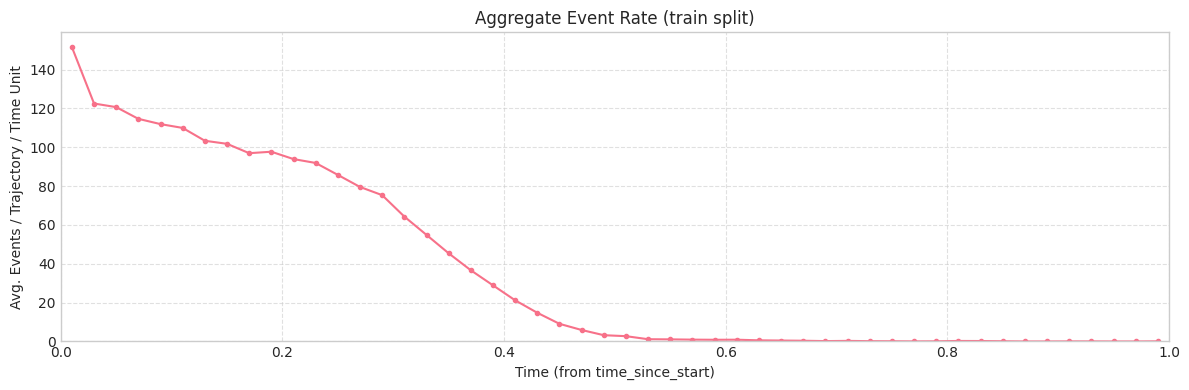

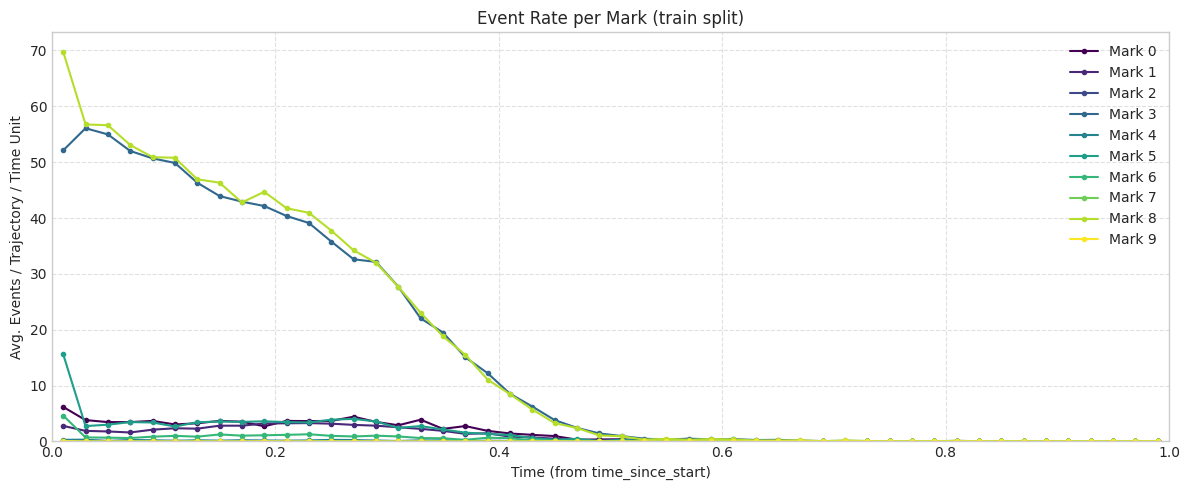

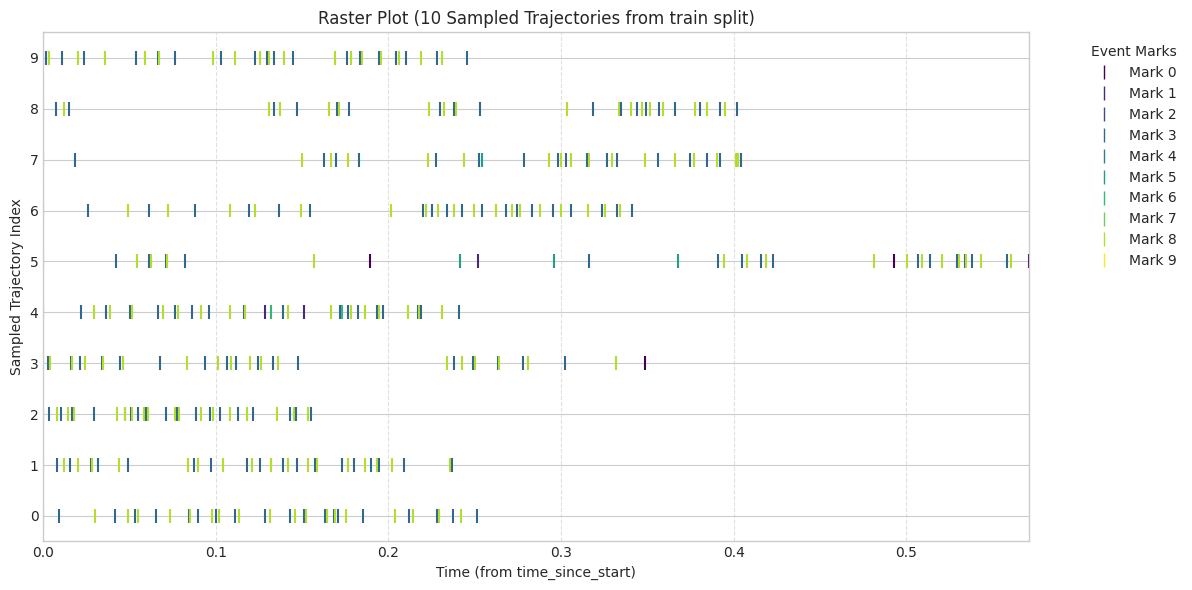

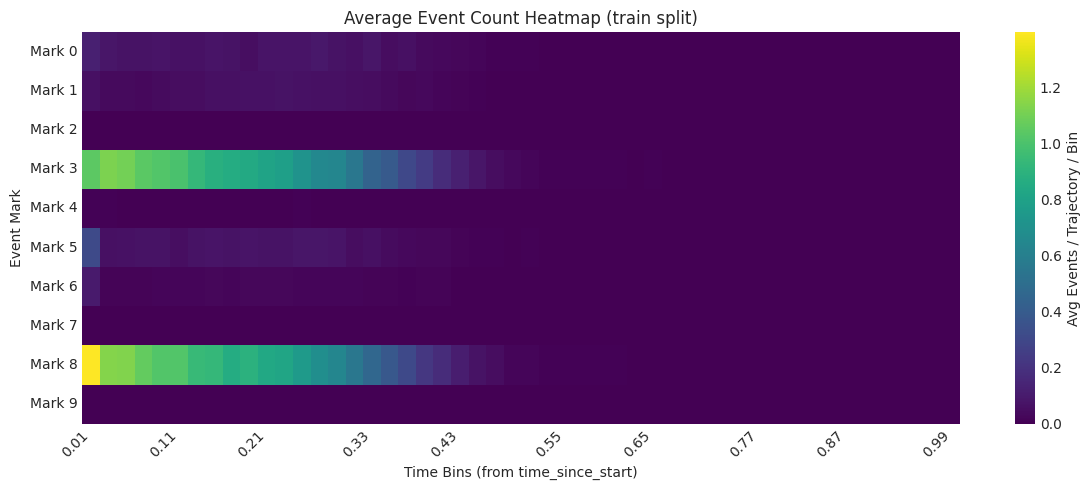

In [45]:
plot_aggregate_rate(taxi_data)

plot_rate_per_mark(taxi_data)

plot_raster_sample(taxi_data)

plot_event_count_heatmap(taxi_data)

In [27]:
# plot_stats_per_event_type(taxi_data, splits=['test'])

## Retweet

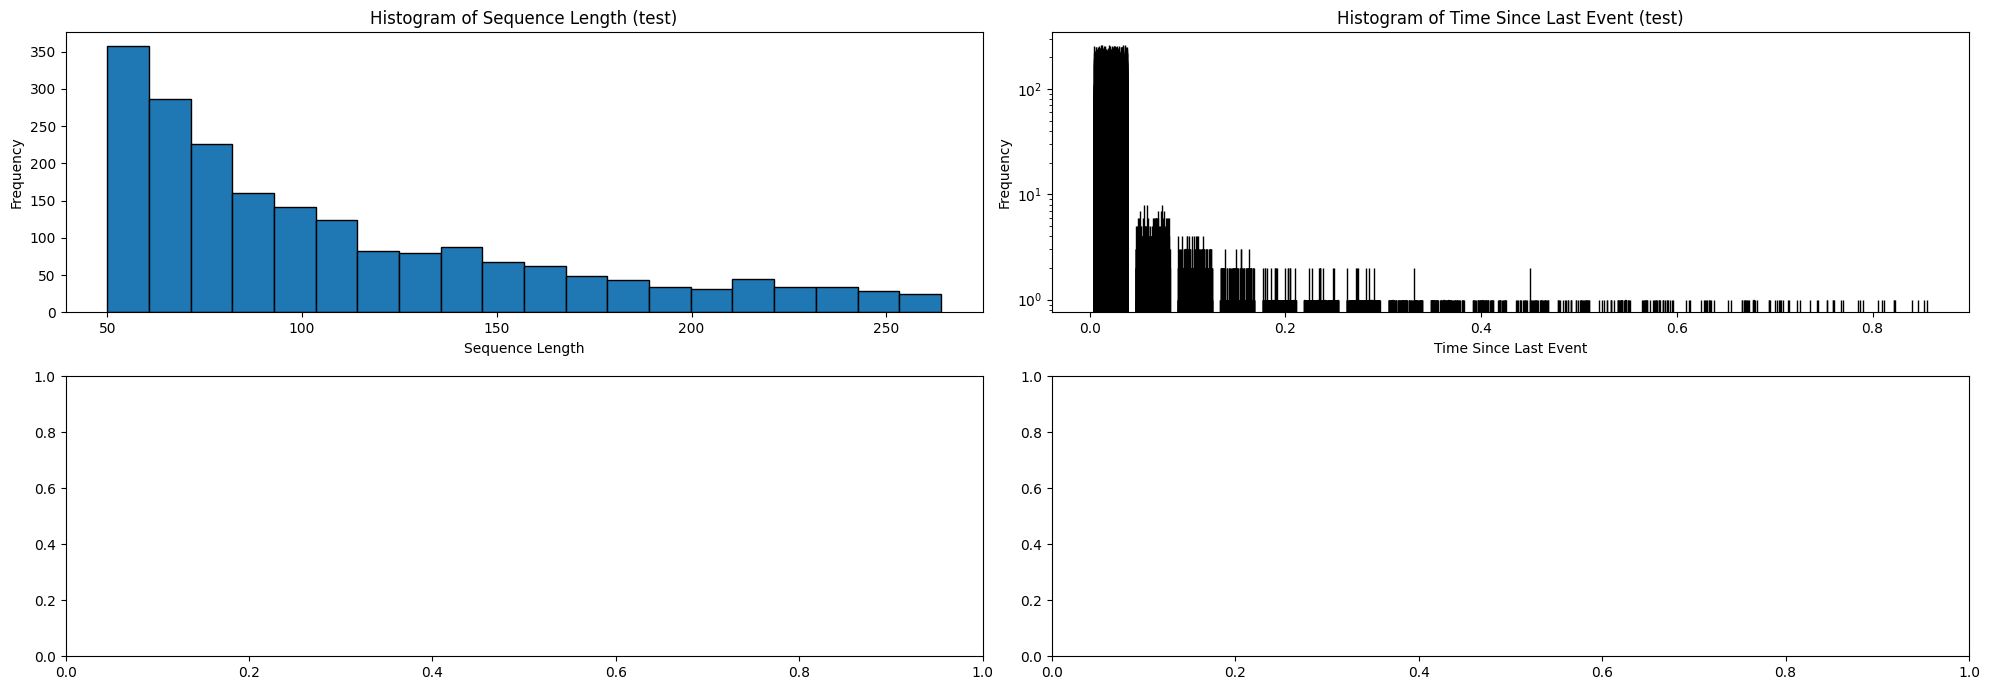

In [28]:
plot_stats(retweet_data, splits=["test"])

In [29]:
# plot_stats_per_event_type(retweet_data, splits=['test'])

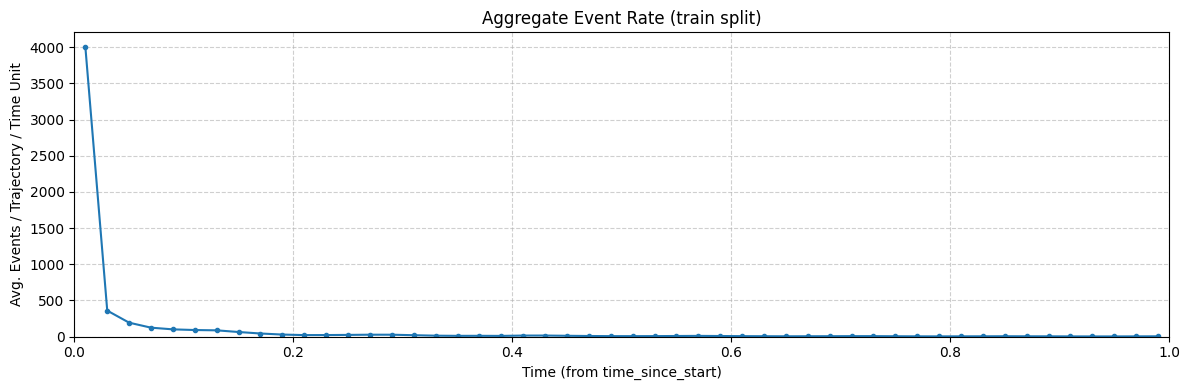

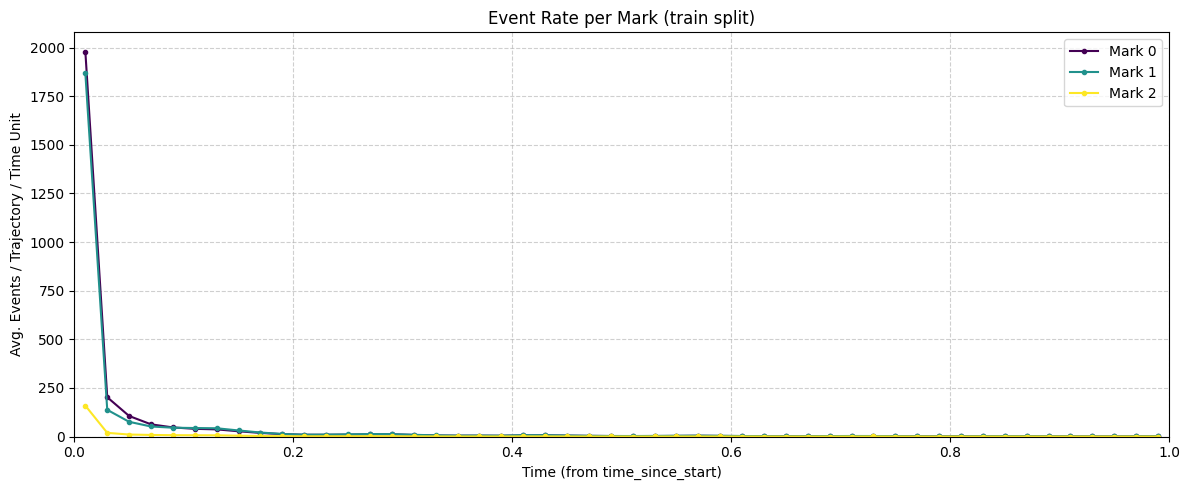

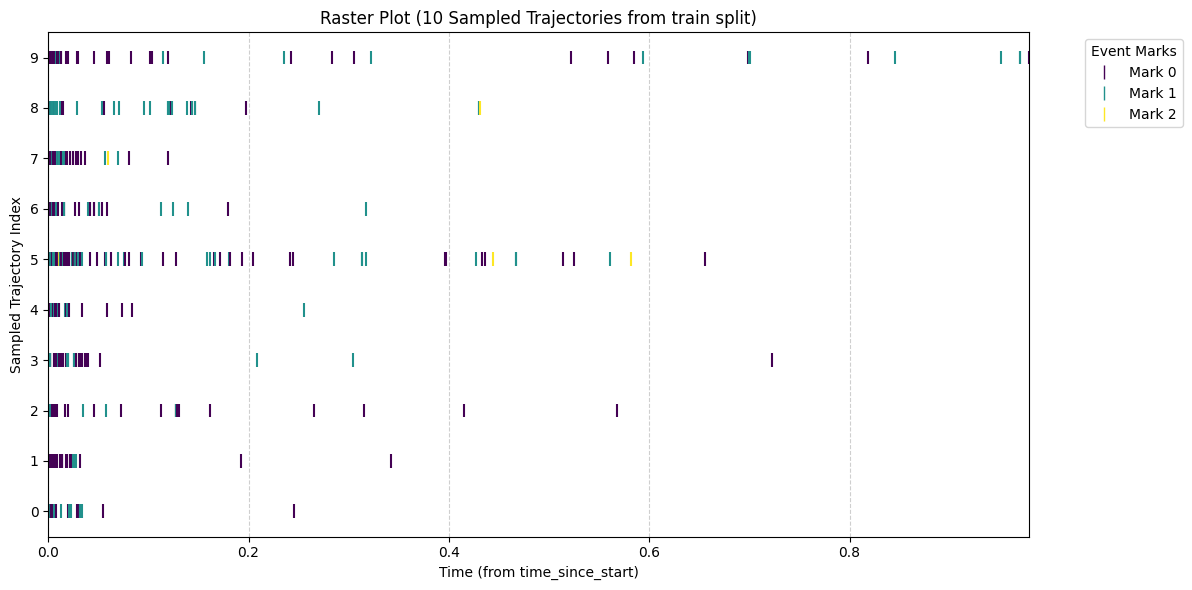

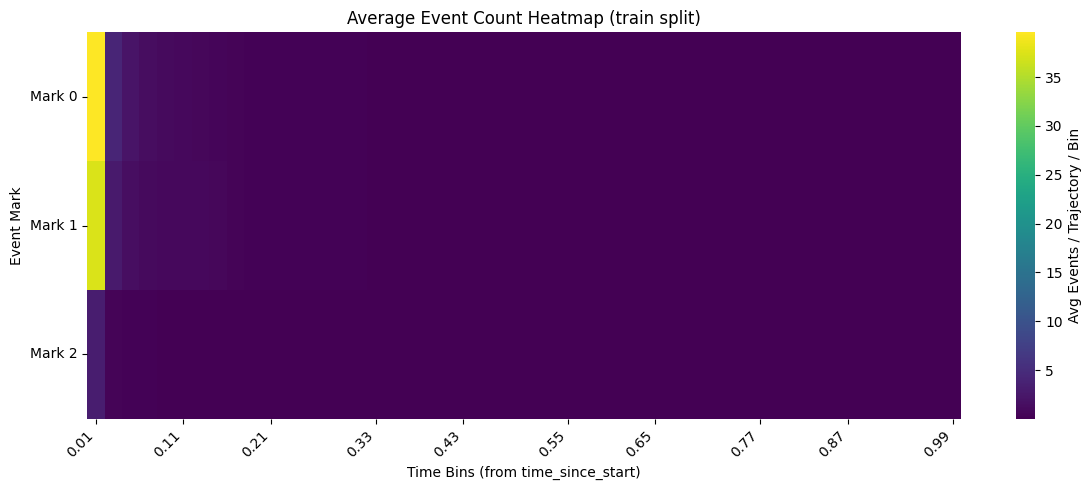

In [30]:
plot_aggregate_rate(retweet_data)

plot_rate_per_mark(retweet_data)

plot_raster_sample(retweet_data)

plot_event_count_heatmap(retweet_data)

## Amazon

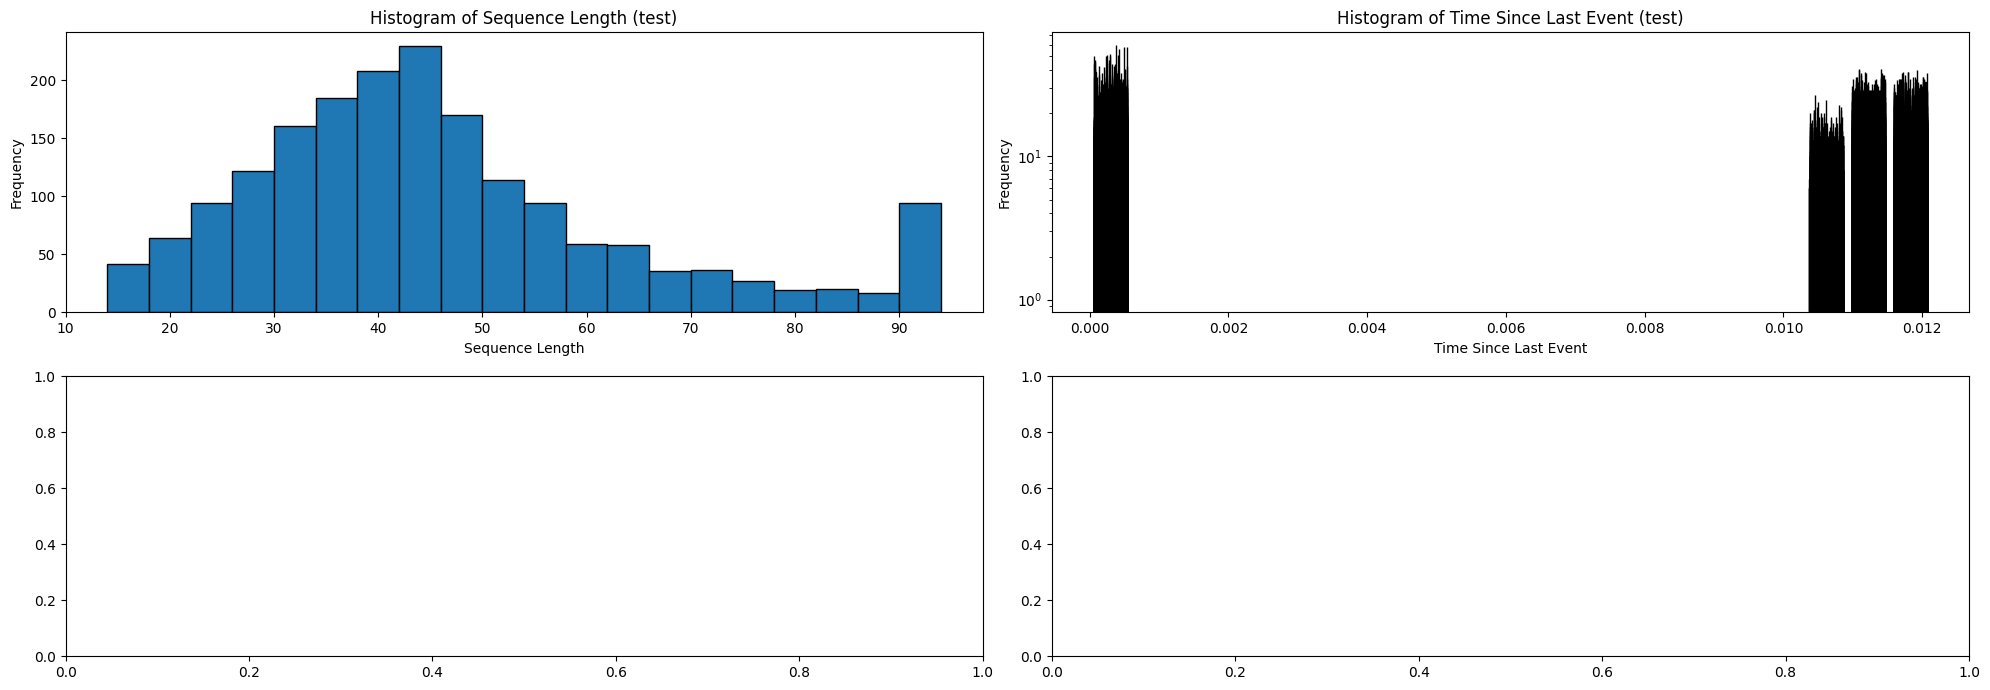

In [31]:
plot_stats(amazon_data, splits=["test"])

In [32]:
# plot_stats_per_event_type(amazon_data, splits=['test'])

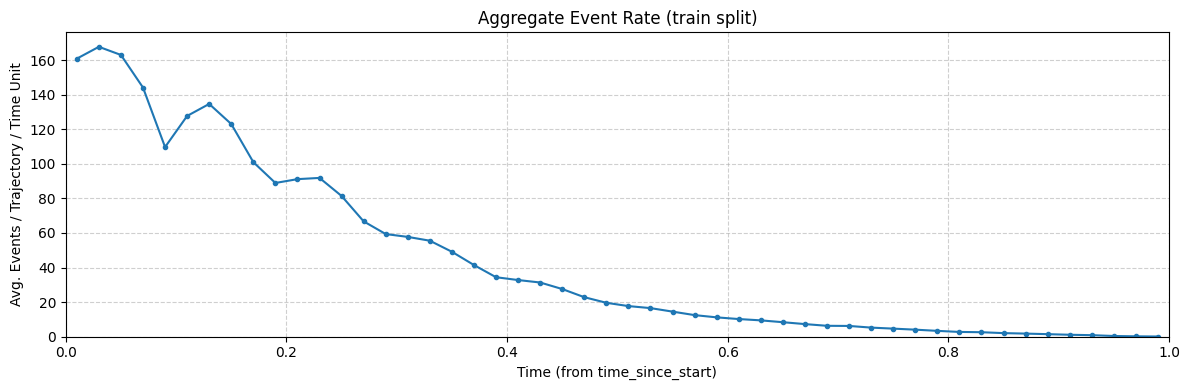

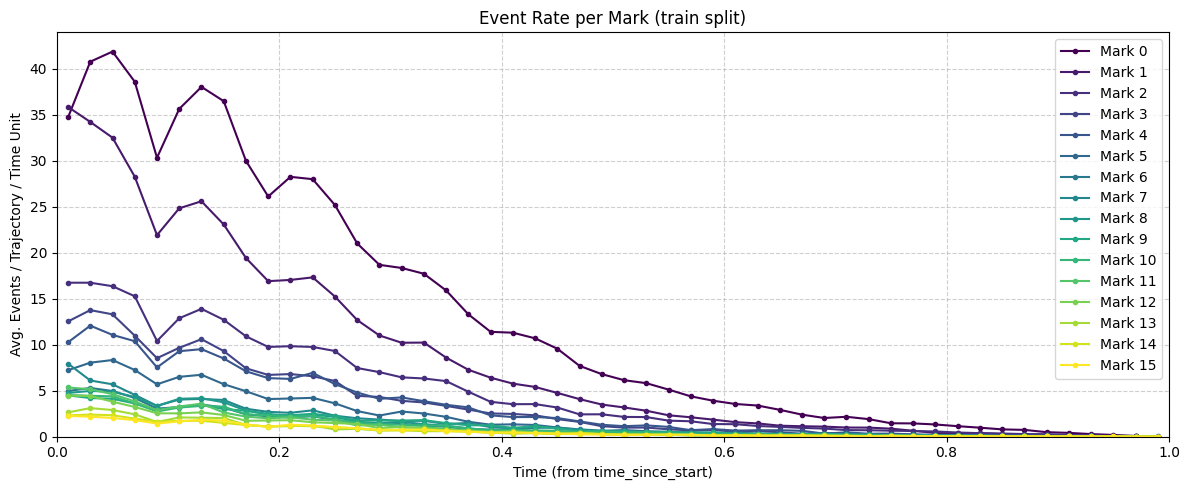

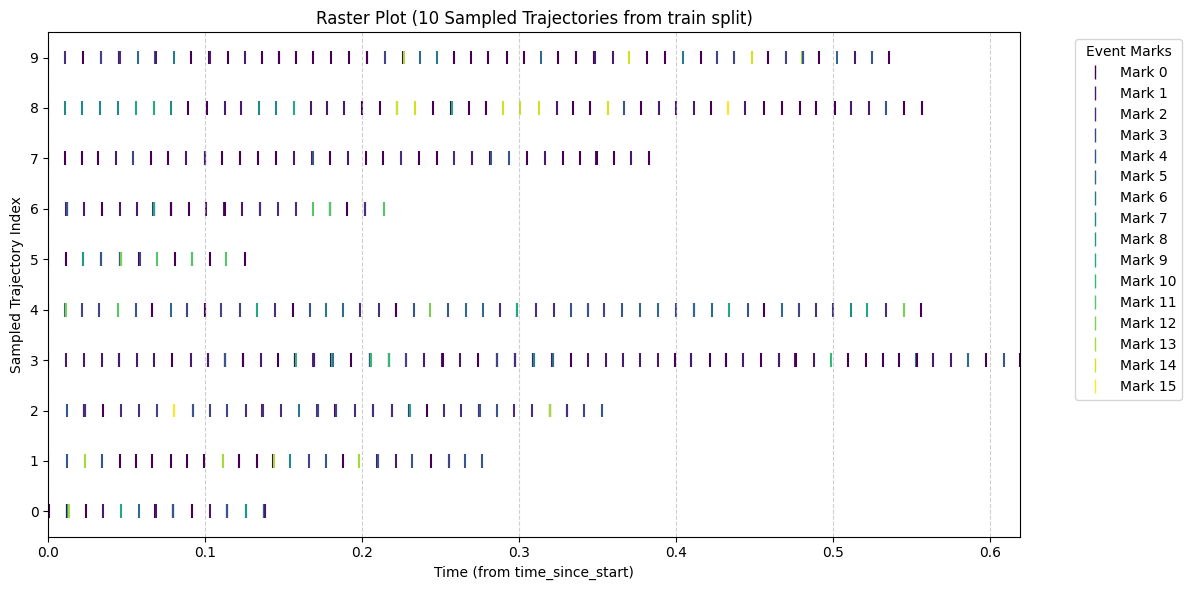

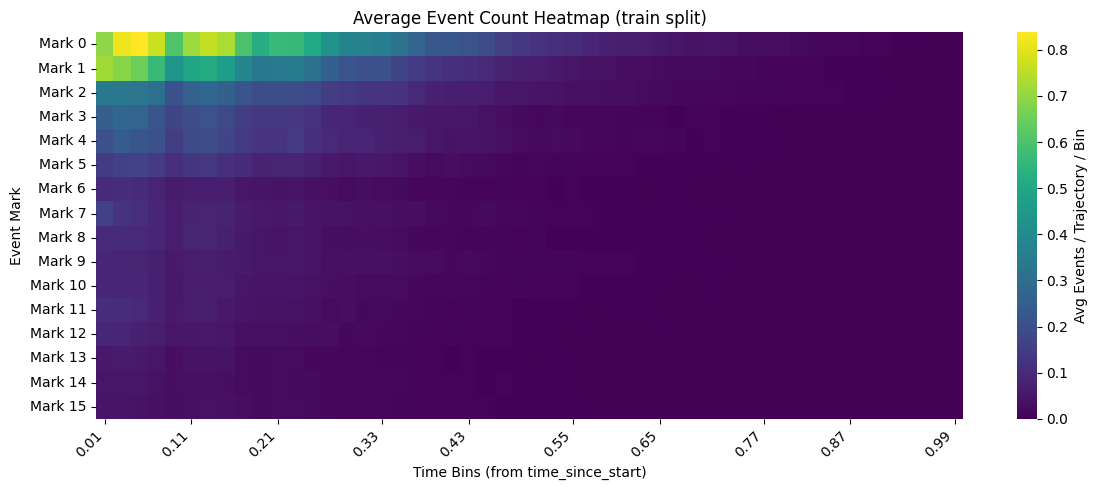

In [33]:
plot_aggregate_rate(amazon_data)

plot_rate_per_mark(amazon_data)

plot_raster_sample(amazon_data)

plot_event_count_heatmap(amazon_data)

## Taobao

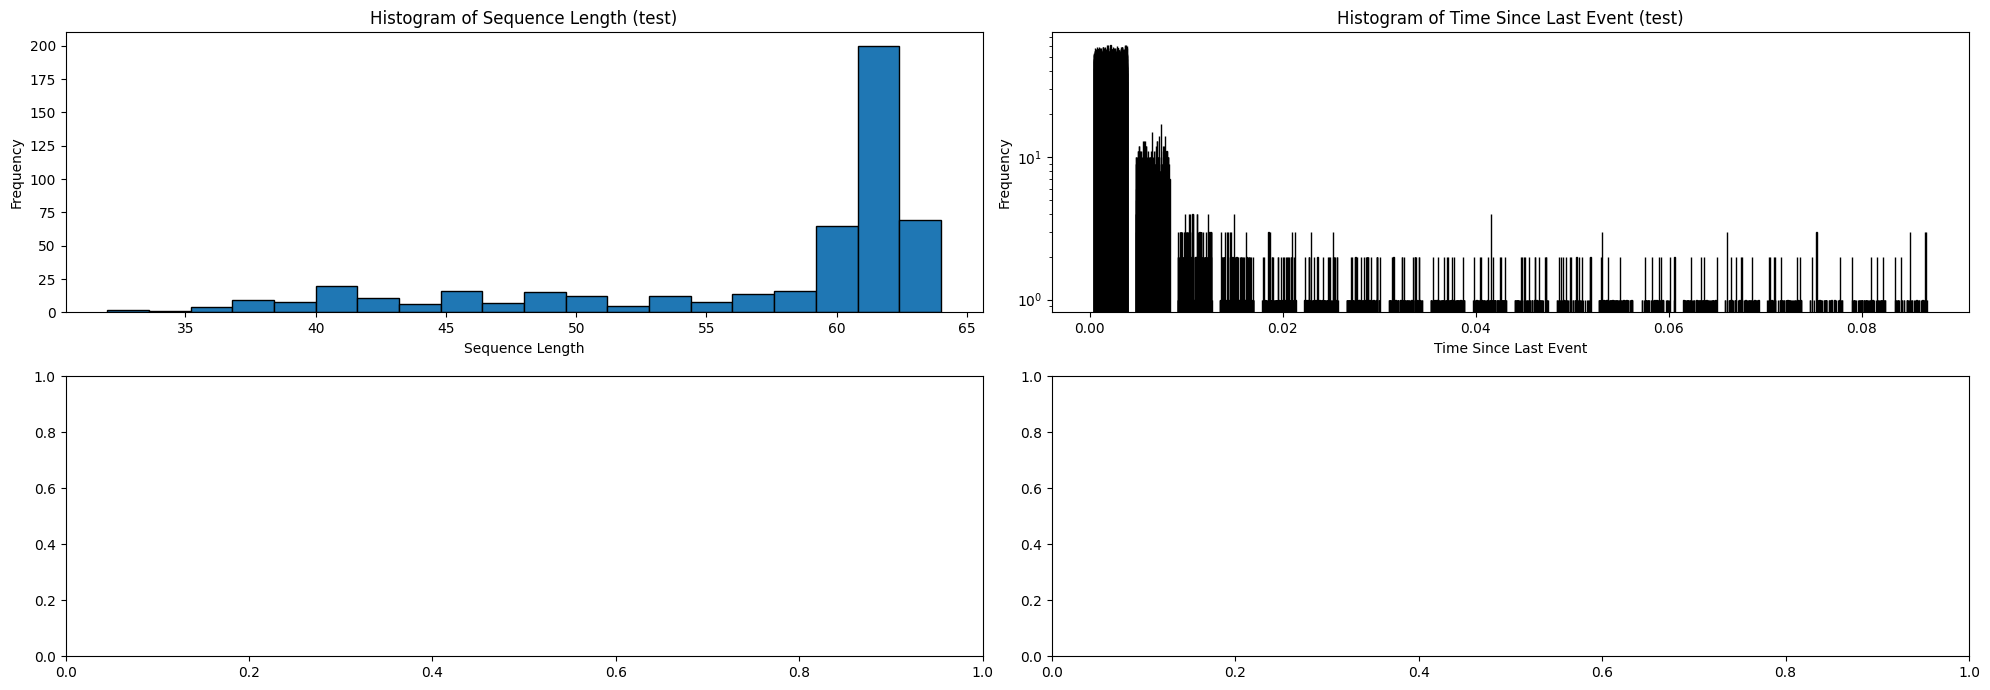

In [34]:
plot_stats(taobao_data, splits=["test"])

In [35]:
# plot_stats_per_event_type(taobao_data, splits=['test'])

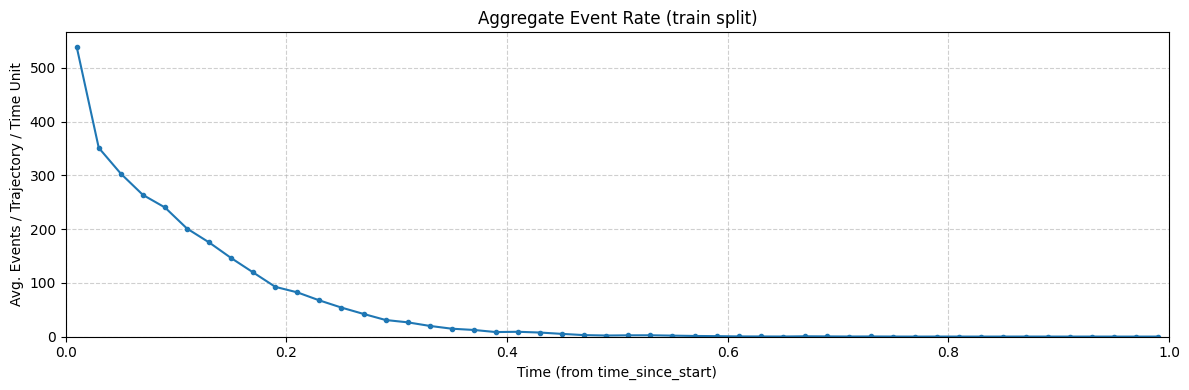

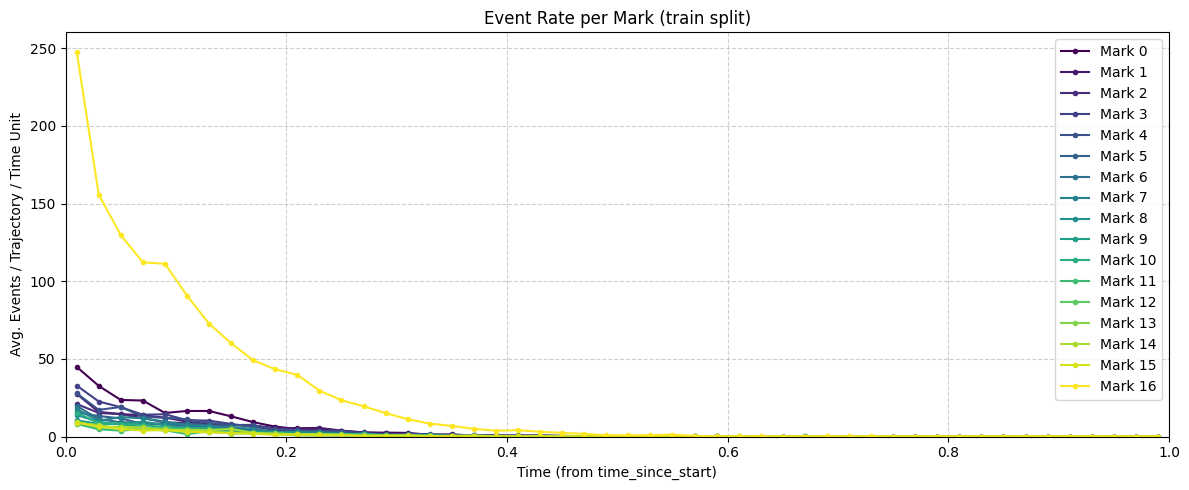

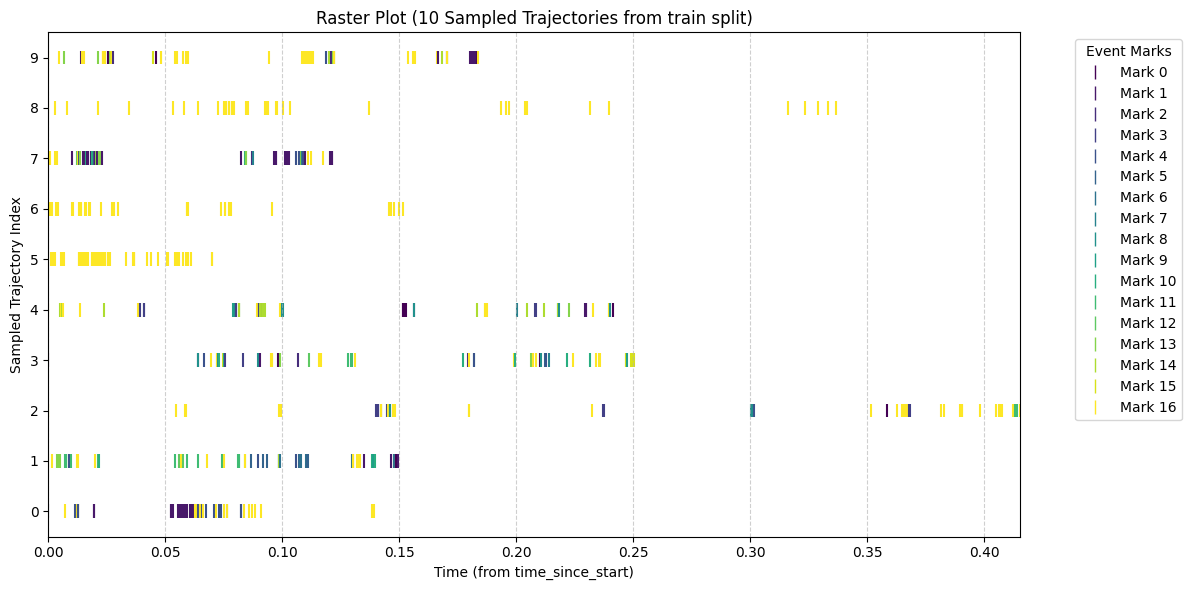

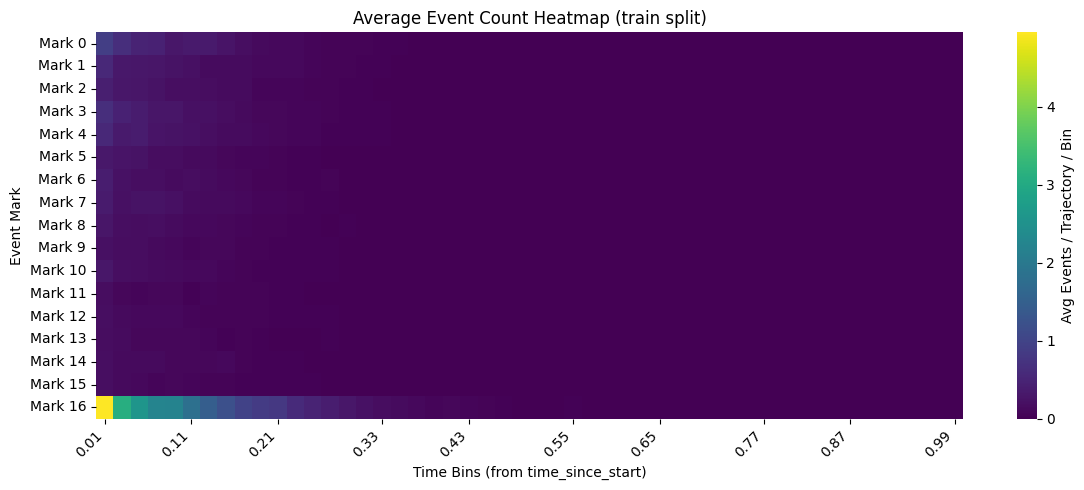

In [36]:
plot_aggregate_rate(taobao_data)

plot_rate_per_mark(taobao_data)

plot_raster_sample(taobao_data)

plot_event_count_heatmap(taobao_data)

## Stackoverflow

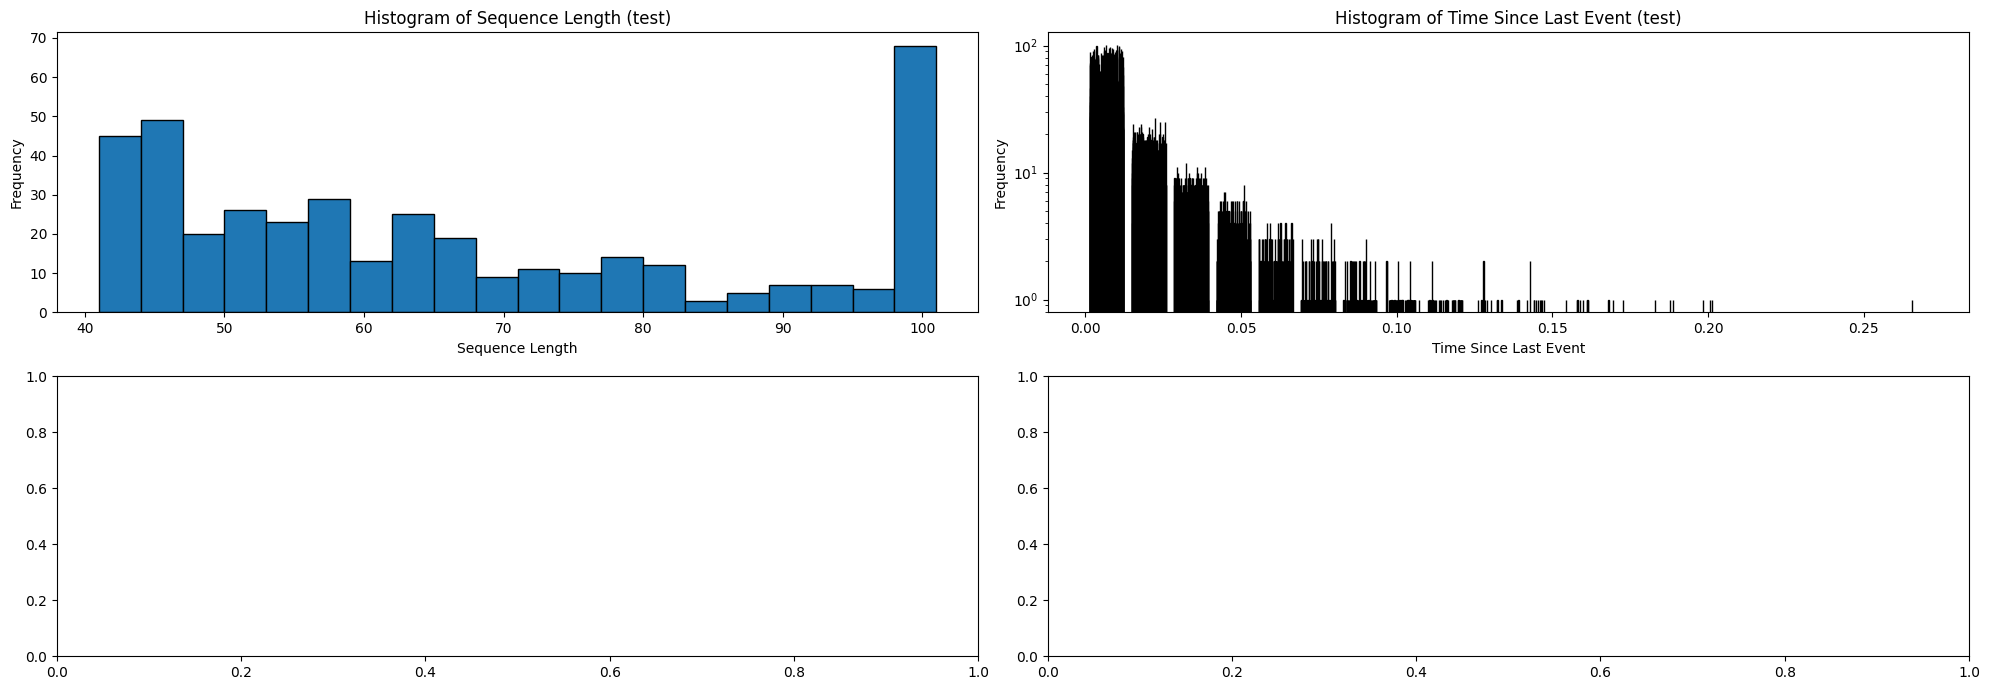

In [37]:
plot_stats(stackoverflow_data, splits=["test"])

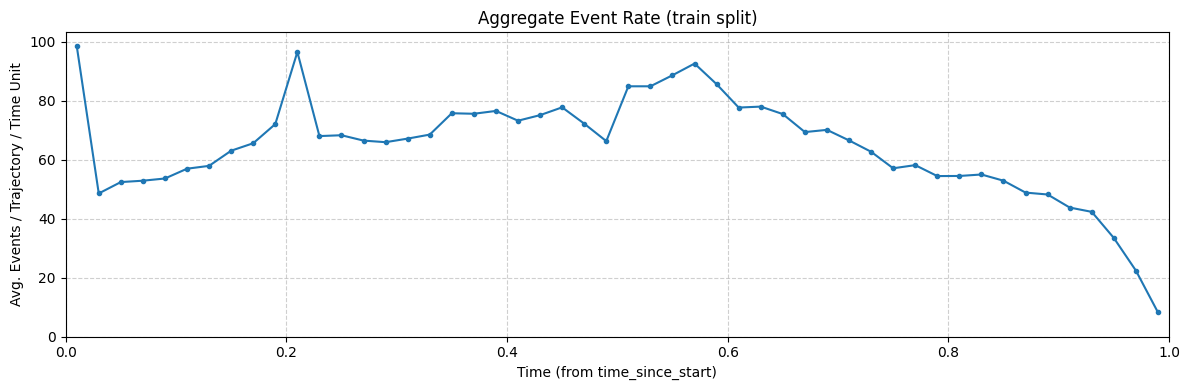

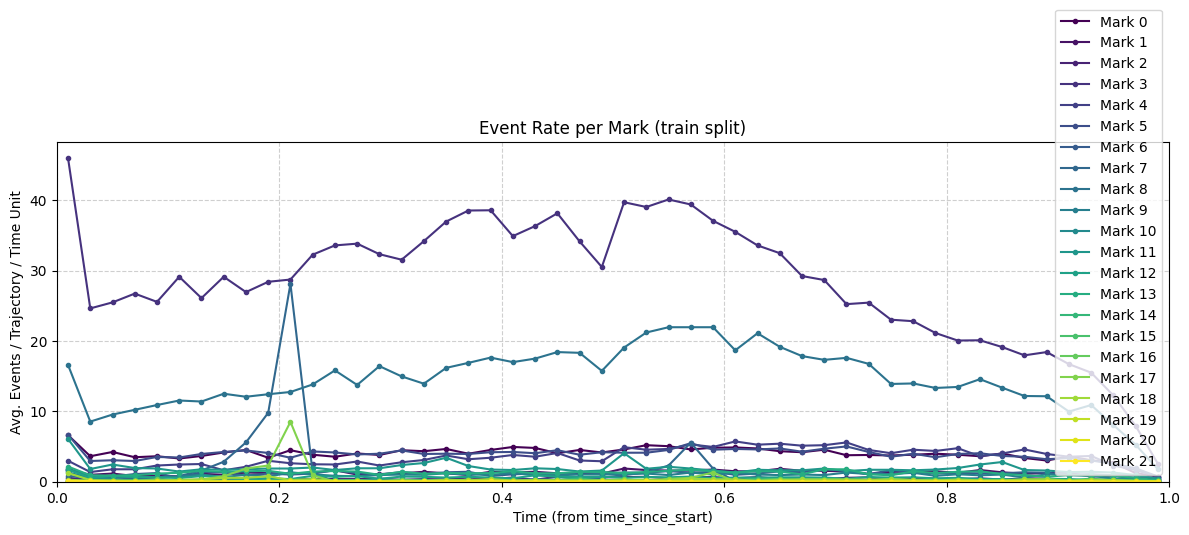

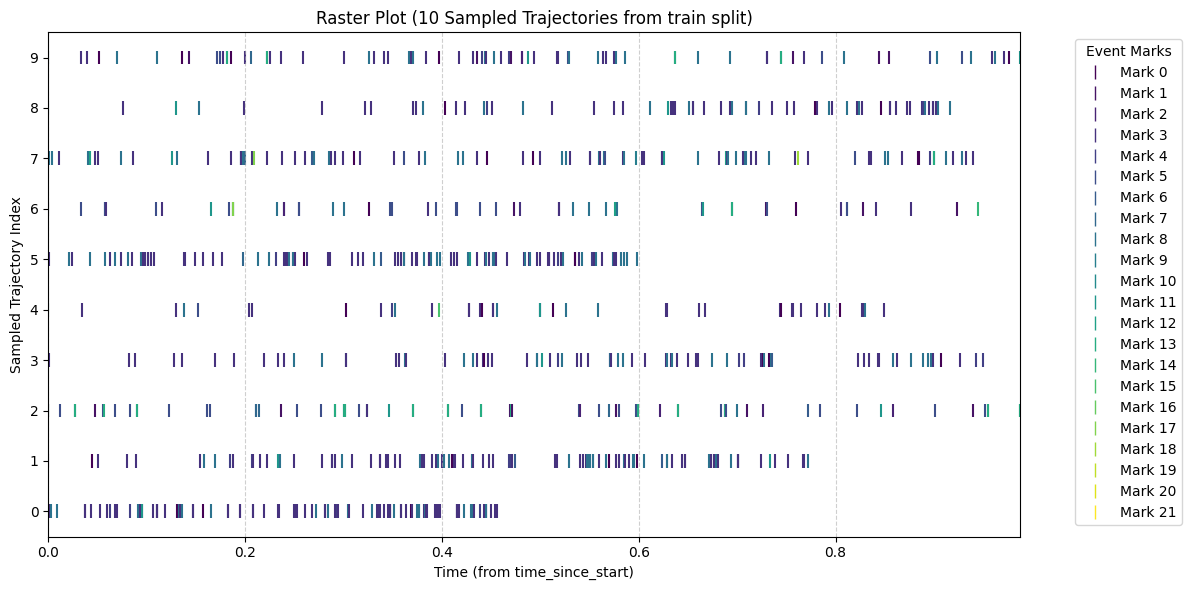

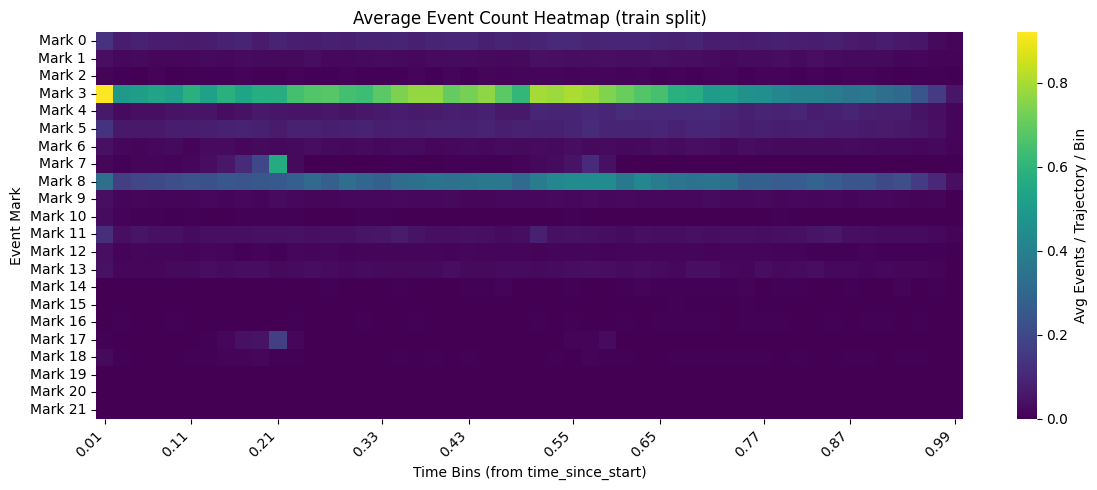

In [38]:
plot_aggregate_rate(stackoverflow_data)

plot_rate_per_mark(stackoverflow_data)

plot_raster_sample(stackoverflow_data)

plot_event_count_heatmap(stackoverflow_data)

In [39]:
# plot_stats_per_event_type(stackoverflow_data, splits=['test'])

In [40]:
import time

import torch
from tick.hawkes import HawkesKernelTimeFunc, SimuHawkes


# ==============================================================================
# == Helper Function: Convert Tick Timestamps
# ==============================================================================


def tick_timestamps_to_single_timeseries(tick_timestamps):
    """
    Converts the list of arrays format from tick library (one array per event type)
    into a single sorted time series with corresponding event types.

    Args:
        tick_timestamps: list[np.array]
            List where each element is a numpy array of event times for a specific type.

    Returns:
        tuple[np.array, np.array]:
            - Sorted event times.
            - Corresponding event types.
    """
    # Handle cases where some event types might have no events
    event_times_list = []
    event_types_list = []
    for event_type, events in enumerate(tick_timestamps):
        # Check if events is a list/array and has content
        if events is not None and hasattr(events, "__len__") and len(events) > 0:
            event_times_list.append(np.asarray(events))
            event_types_list.append(np.full(len(events), event_type, dtype=int))

    if not event_times_list:  # No events simulated
        return np.array([]), np.array([], dtype=int)

    # Concatenate all event times and types
    event_times = np.concatenate(event_times_list)
    event_types = np.concatenate(event_types_list)

    # Sort events chronologically
    sorted_indices = np.argsort(event_times)

    return event_times[sorted_indices], event_types[sorted_indices]


# ==============================================================================
# == Kernel Function Classes
# ==============================================================================


class HawkesExpKernel:
    """
    Evaluates an exponential kernel function: a_0 * exp(-a_1 * t).
    """

    def __init__(self, a_0: float, a_1: float) -> None:
        if a_1 <= 0:
            raise ValueError("Decay rate a_1 must be positive.")
        self.a_0 = a_0
        self.a_1 = a_1

    def __call__(self, grid_size: int, max_time: float = None, eps: float = 1e-3):
        if abs(self.a_0) <= eps:  # Handle cases where amplitude is very small or zero
            max_time_calc = 1.0  # Default to a small interval
        elif max_time is None:
            max_time_calc = -np.log(eps / abs(self.a_0)) / self.a_1
        else:
            max_time_calc = max_time
        max_time_calc = max(max_time_calc, eps)  # Ensure max_time is positive
        t_grid = np.linspace(0, max_time_calc, grid_size)
        kernel_values = self.a_0 * np.exp(-self.a_1 * t_grid)
        return t_grid, kernel_values


class HawkesExpSquaredKernel:
    """
    Evaluates an exponential-squared kernel function: a_0 * t * exp(-a_1 * t^2).
    """

    def __init__(self, a_0: float, a_1: float) -> None:
        if a_1 <= 0:
            raise ValueError("Decay rate a_1 must be positive.")
        self.a_0 = a_0
        self.a_1 = a_1

    def __call__(self, grid_size: int, max_time: float = None, eps: float = 1e-3):
        if max_time is None:
            peak_time = np.sqrt(1.0 / (2.0 * self.a_1)) if self.a_1 > 0 else 0
            try:
                if abs(self.a_0) > 1e-9 and self.a_1 > 1e-9:
                    # Heuristic based on exponential decay part
                    log_term = -np.log(eps / abs(self.a_0 * max(peak_time, 1.0))) / self.a_1  # Rough estimate
                    max_time_calc = np.sqrt(max(log_term, 1.0))
                else:
                    max_time_calc = 5.0 * peak_time  # Fallback heuristic
            except (OverflowError, ValueError, RuntimeWarning):
                max_time_calc = 5.0 * peak_time  # Fallback heuristic
            max_time_calc = max(max_time_calc, 5.0 * peak_time, eps)  # Ensure covers peak and is positive
        else:
            max_time_calc = max_time

        t_grid = np.linspace(0, max_time_calc, grid_size)
        kernel_values = self.a_0 * t_grid * np.exp(-self.a_1 * t_grid**2)
        return t_grid, kernel_values


class HawkesExpShiftedKernel:
    """
    Evaluates a shifted exponential (Gaussian-like) kernel function:
    a_0 * exp(-(t - a_1)^2 / (2 * a_2^2)).
    """

    def __init__(self, a_0: float, a_1: float, a_2: float) -> None:
        if a_2 <= 0:
            raise ValueError("Spread parameter a_2 must be positive.")
        self.a_0 = a_0
        self.a_1 = a_1  # Center
        self.a_2 = a_2  # Std dev

    def __call__(self, grid_size: int, max_time: float = None, eps: float = 1e-3):
        if max_time is None:
            if abs(self.a_0) <= eps:  # Handle low amplitude
                max_time_calc = self.a_1 + 3 * self.a_2  # Go 3 standard deviations out
            else:
                try:
                    # Calculate time t where Gaussian drops to eps
                    log_term = -2 * self.a_2**2 * np.log(eps / abs(self.a_0))
                    if log_term < 0:  # log argument was > 1 (eps > |a_0|)
                        max_time_calc = self.a_1 + 3 * self.a_2  # Fallback
                    else:
                        max_time_calc = self.a_1 + np.sqrt(log_term)
                except (ValueError, OverflowError, RuntimeWarning):
                    max_time_calc = self.a_1 + 3 * self.a_2  # Fallback
            max_time_calc = max(max_time_calc, self.a_1 + 3 * self.a_2, eps)  # Ensure covers peak+decay, positive
        else:
            max_time_calc = max_time

        t_grid = np.linspace(0, max_time_calc, grid_size)
        kernel_values = self.a_0 * np.exp(-((t_grid - self.a_1) ** 2) / (2 * self.a_2**2))
        kernel_values[t_grid < 0] = 0  # Ensure kernel is zero for t < 0
        return t_grid, kernel_values


class HawkesExpSinKernel:
    """
    Evaluates an exponentially decaying sinusoidal kernel function:
    a_0 * sin(a_2 * t) * exp(-a_1 * t).
    """

    def __init__(self, a_0: float, a_1: float, a_2: float) -> None:
        if a_1 <= 0:
            raise ValueError("Decay rate a_1 must be positive.")
        self.a_0 = a_0
        self.a_1 = a_1  # Decay
        self.a_2 = a_2  # Frequency

    def __call__(self, grid_size: int, max_time: float = None, eps: float = 1e-3):
        if max_time is None:
            if abs(self.a_0) <= eps:
                max_time_calc = 1.0  # Default small interval
            else:
                max_time_calc = -np.log(eps / abs(self.a_0)) / self.a_1
        else:
            max_time_calc = max_time
        max_time_calc = max(max_time_calc, eps)  # Ensure max_time is positive
        t_grid = np.linspace(0, max_time_calc, grid_size)
        kernel_values = self.a_0 * np.sin(self.a_2 * t_grid) * np.exp(-self.a_1 * t_grid)
        return t_grid, kernel_values


class HawkesPowerLawKernel:
    """
    Evaluates a power-law kernel function: a_0 * (t + c)^(-a_1).
    """

    def __init__(self, a_0: float, a_1: float, c: float) -> None:
        if a_1 <= 0:
            print(f"Warning: Power-law exponent a_1={a_1} is not positive. Kernel may not decay.")
        if c <= 0:
            raise ValueError("Shift constant c must be positive.")
        self.a_0 = a_0
        self.a_1 = a_1  # Exponent
        self.c = c  # Shift

    def __call__(self, grid_size: int, max_time: float = None, eps: float = 1e-3):
        if max_time is None:
            if abs(self.a_0) <= eps or self.a_1 <= 0:  # Handle low amplitude or non-decaying
                max_time_calc = 100.0  # Default large interval
            else:
                try:
                    base = abs(self.a_0) / eps
                    exponent = 1.0 / self.a_1
                    # Prevent overflow by checking large intermediate results
                    if exponent * np.log(base) > np.log(np.finfo(float).max / 2):
                        max_time_calc = 1e6  # Use a large fallback max_time
                    else:
                        max_time_calc = (base) ** exponent - self.c
                except (ValueError, OverflowError, ZeroDivisionError, RuntimeWarning):
                    max_time_calc = 100.0  # Fallback
            max_time_calc = max(max_time_calc, eps)  # Ensure max_time is positive
        else:
            max_time_calc = max_time

        t_grid = np.linspace(0, max_time_calc, grid_size)
        # Add small epsilon to prevent division by zero if t=0 and c is tiny
        kernel_values = self.a_0 * (t_grid + self.c + 1e-12) ** (-self.a_1)
        return t_grid, kernel_values


# ==============================================================================
# == Simulation Function (Using Tick)
# ==============================================================================


def run_hawkes_simulation(baselines, kernel_grids, kernel_evaluations, num_paths, n_events_per_path, track_intensity, seed=0):
    """
    Runs a Hawkes simulation using the tick library.

    Args:
        baselines (np.array): Baseline intensities for each event type (marks). Shape (num_marks,).
        kernel_grids (list[np.array]): List of time grids for each kernel (num_marks items).
        kernel_evaluations (list[np.array]): List of kernel values corresponding to grids (num_marks items).
                                             Assumes diagonal kernels (kernel i affects only type i).
        num_paths (int): Number of independent simulation paths.
        n_events_per_path (int): Maximum number of events to simulate per path.
        track_intensity (bool): Whether to track the intensity function over time.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple:
            - event_times (np.array): Simulated event times [num_paths, n_events_per_path]. Padded with NaNs.
            - event_types (np.array): Simulated event types [num_paths, n_events_per_path]. Padded with -1.
            - intensity_times (list[torch.Tensor] | None): List of time points for tracked intensities (if tracked).
            - intensities (list[torch.Tensor] | None): List of tracked intensity values (if tracked).
    """
    num_marks = len(baselines)
    if not (len(kernel_grids) == num_marks and len(kernel_evaluations) == num_marks):
        raise ValueError("Baselines, kernel_grids, and kernel_evaluations must have the same length (num_marks).")

    # Initialize Hawkes simulator from tick
    hawkes = SimuHawkes(baseline=baselines.tolist(), max_jumps=n_events_per_path, seed=seed, verbose=False)
    hawkes.threshold_negative_intensity(allow=True)  # Allow inhibitory effects

    # Set the diagonal kernels
    for i in range(num_marks):
        t_vals = np.asarray(kernel_grids[i])
        y_vals = np.asarray(kernel_evaluations[i])

        # Ensure grid is valid (non-empty, sorted, starts near 0)
        if len(t_vals) == 0:
            print(f"Warning: Kernel grid for mark {i} is empty. Skipping kernel setting.")
            continue

        t_vals = np.maximum(t_vals, 0)  # Ensure time is non-negative
        sort_idx = np.argsort(t_vals)
        t_vals = t_vals[sort_idx]
        y_vals = y_vals[sort_idx]

        # tick requires the first time point to be exactly 0 for HawkesKernelTimeFunc
        if not np.isclose(t_vals[0], 0):
            y_at_zero = y_vals[0]  # Use first value as approximation for t=0
            t_vals = np.insert(t_vals, 0, 0.0)
            y_vals = np.insert(y_vals, 0, y_at_zero)
            # Remove duplicates if inserting 0 created one
            unique_indices = np.unique(t_vals, return_index=True)[1]
            t_vals = t_vals[unique_indices]
            y_vals = y_vals[unique_indices]

        # Ensure there are at least two points for the kernel function
        if len(t_vals) < 2:
            print(f"Warning: Kernel grid for mark {i} has < 2 points after processing. Using constant kernel.")
            # Create a minimal valid kernel (e.g., constant value at 0)
            t_vals = np.array([0.0, max(t_vals[0] + 1e-3, 1e-3)])  # Add a small time step
            y_vals = np.array([y_vals[0], y_vals[0]])  # Constant value

        try:
            kernel = HawkesKernelTimeFunc(t_values=t_vals, y_values=y_vals)
            hawkes.set_kernel(i, i, kernel)  # Set kernel from type i to type i
        except Exception as e:
            print(f"Error setting kernel for mark {i}: {e}")
            print(f"  t_values: {t_vals}")
            print(f"  y_values: {y_vals}")
            continue  # Skip this kernel if invalid

    # Configure intensity tracking if requested
    if track_intensity:
        min_max_time = float("inf")
        for grid in kernel_grids:
            if len(grid) > 1:
                min_max_time = min(min_max_time, grid[-1])
        intensity_track_step = max(min_max_time / 20, 1e-4) if min_max_time > 1e-6 else 0.01
        hawkes.track_intensity(intensity_track_step)

    # Store results
    all_event_times = []
    all_event_types = []
    all_intensities = []
    all_intensity_times = []

    print(f"Starting Hawkes simulation: {num_paths} paths, {n_events_per_path} events/path, {num_marks} marks.")

    for i in range(num_paths):
        try:
            hawkes.reset()
            hawkes.simulate()

            path_times, path_types = tick_timestamps_to_single_timeseries(hawkes.timestamps)

            first_event_time_orig = path_times[0] if len(path_times) > 0 else 0

            if len(path_times) == 0:
                # print(f"Warning: Path {i} produced 0 events.")
                padded_times = np.full(n_events_per_path, np.nan)
                padded_types = np.full(n_events_per_path, -1, dtype=int)
            else:
                path_times = path_times - first_event_time_orig  # Normalize start time to 0

                current_len = len(path_times)
                if current_len < n_events_per_path:
                    pad_width = n_events_per_path - current_len
                    padded_times = np.pad(path_times, (0, pad_width), "constant", constant_values=np.nan)
                    padded_types = np.pad(path_types, (0, pad_width), "constant", constant_values=-1)
                else:
                    padded_times = path_times[:n_events_per_path]
                    padded_types = path_types[:n_events_per_path]

            all_event_times.append(padded_times)
            all_event_types.append(padded_types)

            if track_intensity:
                tracked_intensity_np = np.array(hawkes.tracked_intensity)
                tracked_intensity_times_np = np.array(hawkes.intensity_tracked_times)

                if len(tracked_intensity_times_np) > 0:
                    # Align intensity time relative to the (original) first event time
                    tracked_intensity_times_np = tracked_intensity_times_np - first_event_time_orig

                all_intensities.append(torch.from_numpy(tracked_intensity_np))
                all_intensity_times.append(torch.from_numpy(tracked_intensity_times_np))

        except Exception as e:
            print(f"Error during simulation path {i}: {e}")
            all_event_times.append(np.full(n_events_per_path, np.nan))
            all_event_types.append(np.full(n_events_per_path, -1, dtype=int))
            if track_intensity:
                all_intensities.append(torch.empty(0))
                all_intensity_times.append(torch.empty(0))
            # Depending on the error, you might want to break or log more details
            # break # Uncomment to stop simulation on first error

    print("Simulation finished.")

    final_event_times = np.stack(all_event_times)
    final_event_types = np.stack(all_event_types)

    return (
        final_event_times,
        final_event_types,
        all_intensity_times if track_intensity else None,
        all_intensities if track_intensity else None,
    )


# ==============================================================================
# == Parameter Definitions (Based on PDF Stats)
# ==============================================================================

# --- Dataset Statistics (Estimates from PDF) ---
dataset_stats = {
    "volcano": {"num_marks": 1, "baseline": 0.1, "avg_len": 7, "max_time": 150},
    "taobao": {"num_marks": 1, "baseline": 0.05, "avg_len": 50, "max_time": 20000},  # Using 1 mark for simplicity
    "retweet": {"num_marks": 1, "baseline": 5.0, "avg_len": 20, "max_time": 2},
    "stackoverflow": {"num_marks": 1, "baseline": 0.1, "avg_len": 10, "max_time": 100},  # Using 1 mark for simplicity
    "taxi": {"num_marks": 2, "baseline": 10.0, "avg_len": 20, "max_time": 1},
    "amazon": {"num_marks": 1, "baseline": 0.02, "avg_len": 10, "max_time": 600},  # Using 1 mark for simplicity
    "earthquake": {"num_marks": 1, "baseline": 0.01, "avg_len": 100, "max_time": 10000},
}

# --- Kernel Parameter Calculation ---
kernel_params = {}
grid_size = 100  # Number of points for kernel evaluation grid

for name, stats in dataset_stats.items():
    kernel_params[name] = {}
    mu = stats["baseline"]
    Tmax = stats["max_time"]
    num_marks = stats["num_marks"]
    avg_len = stats["avg_len"]

    # --- Exponential Kernel ---
    a1_exp = 3.0 / Tmax if Tmax > 1e-6 else 1.0
    a1_exp = max(a1_exp, 1e-6)
    a0_exp = 0.5 * a1_exp  # Norm = 0.5
    kernel_params[name]["Exp"] = {"a_0": a0_exp, "a_1": a1_exp}

    # --- ExpSquared Kernel ---
    a1_expsq = 50.0 / Tmax**2 if Tmax > 1e-3 else 1.0
    a1_expsq = max(a1_expsq, 1e-6)
    a0_expsq = 0.5 * (2 * a1_expsq)  # Norm = 0.5
    kernel_params[name]["ExpSquared"] = {"a_0": a0_expsq, "a_1": a1_expsq}

    # --- ExpShifted Kernel (Gaussian) ---
    a1_shift = Tmax / 5.0 if Tmax > 1e-6 else 0.1
    a2_shift = Tmax / 10.0 if Tmax > 1e-6 else 0.05
    a2_shift = max(a2_shift, 1e-3)
    norm_gauss = 0.5
    a0_shift = norm_gauss / (a2_shift * np.sqrt(2 * np.pi)) if a2_shift > 1e-9 else 0.1
    kernel_params[name]["ExpShifted"] = {"a_0": a0_shift, "a_1": a1_shift, "a_2": a2_shift}

    # --- ExpSin Kernel ---
    a1_expsin = 3.0 / Tmax if Tmax > 1e-6 else 1.0
    a1_expsin = max(a1_expsin, 1e-6)
    a2_expsin = 4 * np.pi / Tmax if Tmax > 1e-6 else np.pi
    a0_expsin = 0.3 * a1_expsin  # Implicit norm ~0.3
    kernel_params[name]["ExpSin"] = {"a_0": a0_expsin, "a_1": a1_expsin, "a_2": a2_expsin}

    # --- PowerLaw Kernel ---
    a1_pow = 1.1
    avg_inter_event = Tmax / avg_len if avg_len > 0 and Tmax > 0 else 1.0
    c_pow = max(0.1 * avg_inter_event, 0.01)
    norm_pow = 0.5
    if c_pow > 1e-9 and a1_pow > 1.0:
        a0_pow = norm_pow * (a1_pow - 1) * (c_pow ** (a1_pow - 1))
    else:
        a0_pow = 0.1  # Fallback
    if name == "earthquake":  # Adjust for very long timescale
        a1_pow = 1.05
        c_pow = max(0.01 * avg_inter_event, 0.1)
        if c_pow > 1e-9 and a1_pow > 1.0:
            a0_pow = norm_pow * (a1_pow - 1) * (c_pow ** (a1_pow - 1))
        else:
            a0_pow = 0.05  # Fallback
    kernel_params[name]["PowerLaw"] = {"a_0": a0_pow, "a_1": a1_pow, "c": c_pow}

# --- Map Kernel Names to Classes ---
kernel_classes = {
    "Exp": HawkesExpKernel,
    "ExpSquared": HawkesExpSquaredKernel,
    "ExpShifted": HawkesExpShiftedKernel,
    "ExpSin": HawkesExpSinKernel,
    "PowerLaw": HawkesPowerLawKernel,
}

# ==============================================================================
# == Simulation Execution
# ==============================================================================

# --- Simulation Setup ---
num_paths = 50  # Number of sequences to generate per dataset/kernel
track_intensity = False  # Set to True to track intensity (can be slow)
simulation_seed = 42  # For reproducibility

# Store generated data: results[dataset_name][kernel_name] = (times, types, intensity_times, intensities)
synthetic_data = {}

# --- Run Simulations ---
print("Starting data generation...")
overall_start_time = time.time()

for dataset_name, stats in dataset_stats.items():
    print(f"\n--- Processing Dataset: {dataset_name} ---")
    synthetic_data[dataset_name] = {}
    num_marks = stats["num_marks"]
    n_events = int(stats["avg_len"])  # Target number of events
    # Distribute baseline evenly among marks (adjust if specific per-mark baselines needed)
    baselines = np.full(num_marks, stats["baseline"] / num_marks) if num_marks > 0 else np.array([])
    baselines = np.maximum(baselines, 1e-9)  # Ensure baseline is positive

    for kernel_name, KernelClass in kernel_classes.items():
        print(f"  Kernel: {kernel_name}")
        params = kernel_params[dataset_name][kernel_name]

        # Create kernel instance
        try:
            kernel_instance = KernelClass(**params)
        except Exception as e:
            print(f"    Error initializing kernel {kernel_name} for {dataset_name}: {e}")
            continue

        # Evaluate kernel on grid
        try:
            # Use dataset's max_time as a hint for the grid range
            t_grid, kernel_vals = kernel_instance(grid_size=grid_size, max_time=stats["max_time"])
        except Exception as e:
            print(f"    Error evaluating kernel {kernel_name} for {dataset_name}: {e}")
            continue

        # Prepare inputs for simulation (diagonal kernels)
        kernel_grids = [t_grid] * num_marks
        kernel_evaluations = [kernel_vals] * num_marks

        # Run simulation
        sim_results = run_hawkes_simulation(
            baselines=baselines,
            kernel_grids=kernel_grids,
            kernel_evaluations=kernel_evaluations,
            num_paths=num_paths,
            n_events_per_path=n_events,
            track_intensity=track_intensity,
            seed=simulation_seed,
        )

        # Store results
        synthetic_data[dataset_name][kernel_name] = sim_results
        # Add a small delay if needed, e.g., time.sleep(0.1)

overall_end_time = time.time()
print("\n--- Simulation Complete ---")
print(f"Total time: {overall_end_time - overall_start_time:.2f} seconds")

# ==============================================================================
# == Example Usage: Accessing Data and Plotting
# ==============================================================================

# --- Example: Accessing generated data ---
try:
    amazon_exp_times, amazon_exp_types, _, _ = synthetic_data["amazon"]["Exp"]
    print(f"\nExample: Amazon Exp Kernel - Event times shape: {amazon_exp_times.shape}")
    # Print first 10 events of the first path (excluding NaNs)
    first_path_valid_times = amazon_exp_times[0, ~np.isnan(amazon_exp_times[0, :])]
    print(f"First path, first 10 events: {first_path_valid_times[:10]}")
except KeyError:
    print("\nCould not retrieve example data for Amazon Exp Kernel.")
except Exception as e:
    print(f"\nError accessing example data: {e}")


# --- Optional: Plot a sample kernel and a sample path ---
def plot_example(dataset="retweet", kernel="Exp"):
    print(f"\nPlotting example for: Dataset={dataset}, Kernel={kernel}")
    if dataset not in synthetic_data or kernel not in synthetic_data[dataset]:
        print(f"--> Data for {dataset} with {kernel} kernel not available.")
        return
    if dataset not in dataset_stats or kernel not in kernel_params.get(dataset, {}):
        print(f"--> Parameter definition for {dataset}/{kernel} not found.")
        return

    plt.style.use("seaborn-v0_8-whitegrid")  # Use a nice style
    plt.figure(figsize=(12, 5))

    # Plot Kernel
    ax1 = plt.subplot(1, 2, 1)
    try:
        params = kernel_params[dataset][kernel]
        KernelClass = kernel_classes[kernel]
        kernel_instance = KernelClass(**params)
        # Use a finer grid for plotting the kernel shape
        t_grid_plot, kernel_vals_plot = kernel_instance(grid_size=200, max_time=dataset_stats[dataset]["max_time"])

        ax1.plot(t_grid_plot, kernel_vals_plot, label=f"{kernel} Kernel", color="blue", linewidth=2)
        ax1.set_title(f"{dataset} - {kernel} Kernel")
        ax1.set_xlabel("Time Lag (t)")
        ax1.set_ylabel("Kernel Value phi(t)")
        ax1.grid(True, linestyle="--", alpha=0.7)
        ax1.legend()
        # Set y-limits to be reasonable, avoiding extreme values if kernel explodes
        min_val = np.min(kernel_vals_plot[np.isfinite(kernel_vals_plot)])
        max_val = np.max(kernel_vals_plot[np.isfinite(kernel_vals_plot)])
        padding = (max_val - min_val) * 0.1
        ax1.set_ylim(min_val - padding, max_val + padding)

    except Exception as e:
        print(f"--> Error plotting kernel: {e}")
        ax1.text(0.5, 0.5, "Error plotting kernel", ha="center", va="center")
        ax1.set_title(f"{dataset} - {kernel} Kernel (Error)")

    # Plot Raster for first path
    ax2 = plt.subplot(1, 2, 2)
    try:
        event_times, event_types, _, _ = synthetic_data[dataset][kernel]
        path_index = 0
        times_path = event_times[path_index, :]
        types_path = event_types[path_index, :]

        # Filter out padding NaNs/-1 types
        valid_indices = ~np.isnan(times_path) & (types_path >= 0)
        times_path = times_path[valid_indices]
        types_path = types_path[valid_indices]

        num_events_in_path = len(times_path)
        if num_events_in_path > 0:
            num_marks_actual = dataset_stats[dataset]["num_marks"]
            # Define colors for marks
            colors = plt.cm.viridis(np.linspace(0, 1, max(num_marks_actual, 2)))  # Need at least 2 colors for cmap

            # Create data suitable for eventplot (list of arrays, one per mark)
            event_data = []
            mark_indices = []
            for i in range(num_marks_actual):
                mark_times = times_path[types_path == i]
                if len(mark_times) > 0:
                    event_data.append(mark_times)
                    mark_indices.append(i)  # Keep track of which marks have events

            if event_data:  # Only plot if there are events
                # Use colors corresponding to the marks that actually have events
                plot_colors = [colors[i] for i in mark_indices]
                ax2.eventplot(event_data, linelengths=0.8, colors=plot_colors, lineoffsets=mark_indices)
                ax2.set_yticks(mark_indices)
                ax2.set_yticklabels([f"Mark {i}" for i in mark_indices])
            else:  # Handle case where filtering removed all events (e.g., all were padding)
                ax2.text(0.5, 0.5, "No valid events in sample path", ha="center", va="center")

            ax2.set_title(f"Sample Path {path_index} ({num_events_in_path} events)")
            ax2.set_xlabel("Time")
            ax2.set_ylabel("Event Type (Mark)")
            ax2.grid(True, linestyle="--", alpha=0.7, axis="x")  # Grid only on x-axis for clarity
            # Set x-limit based on the last event time
            if num_events_in_path > 0:
                ax2.set_xlim(0, times_path[-1] * 1.05)  # Add 5% padding

        else:
            ax2.text(0.5, 0.5, "No events in sample path", ha="center", va="center")
            ax2.set_title(f"Sample Path {path_index} (0 events)")
            ax2.set_yticks([])

    except Exception as e:
        print(f"--> Error plotting raster: {e}")
        ax2.text(0.5, 0.5, "Error plotting raster", ha="center", va="center")
        ax2.set_title(f"Sample Path {path_index} (Error)")

    plt.tight_layout()
    plt.show()


# --- Plot Examples ---
# You can uncomment these lines one by one or change the parameters
# to see different results after the simulation runs.
# plot_example(dataset='retweet', kernel='Exp')
# plot_example(dataset='earthquake', kernel='PowerLaw')
# plot_example(dataset='taxi', kernel='Exp')
# plot_example(dataset='volcano', kernel='ExpShifted')
# plot_example(dataset='amazon', kernel='ExpSquared')

# Example: Plotting after the script finishes (assuming execution in interactive environment)
if __name__ == "__main__":
    # Plot a few examples automatically after running the script
    plot_example(dataset="retweet", kernel="Exp")
    plot_example(dataset="earthquake", kernel="PowerLaw")
    plot_example(dataset="taxi", kernel="ExpSquared")

ModuleNotFoundError: No module named 'tick'